In [173]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
from datetime import datetime
import plotly
plotly.offline.init_notebook_mode (connected = True)
import plotly.express as px
import matplotlib.pyplot as plt
import squarify
import matplotlib.colors as mcolors
from sklearn.cluster import KMeans
from sklearn.decomposition import KernelPCA,PCA,TruncatedSVD
import spacy
import en_core_web_sm
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import calendar

In [177]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va                       # Vertically align label
        )


In [179]:
import os

file_path = "C:/Users/Khushi Gangrade/Desktop/projectss/E-commerce Analysis/data1.csv"
print("Exists:", os.path.exists(file_path))

Exists: True


In [181]:
df = pd.read_csv(
    r"C:\Users\Khushi Gangrade\Desktop\projectss\E-commerce Analysis\data1.csv",
    parse_dates=['InvoiceDate'],
    encoding='ISO-8859-1'  # or 'latin1'
)
df_original = df.copy()
df.head()


InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [183]:
df.describe()

Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303

In [315]:
df[['Quantity', 'UnitPrice', 'CustomerID']].isnull().sum()


Quantity           0
UnitPrice          0
CustomerID    134658
dtype: int64

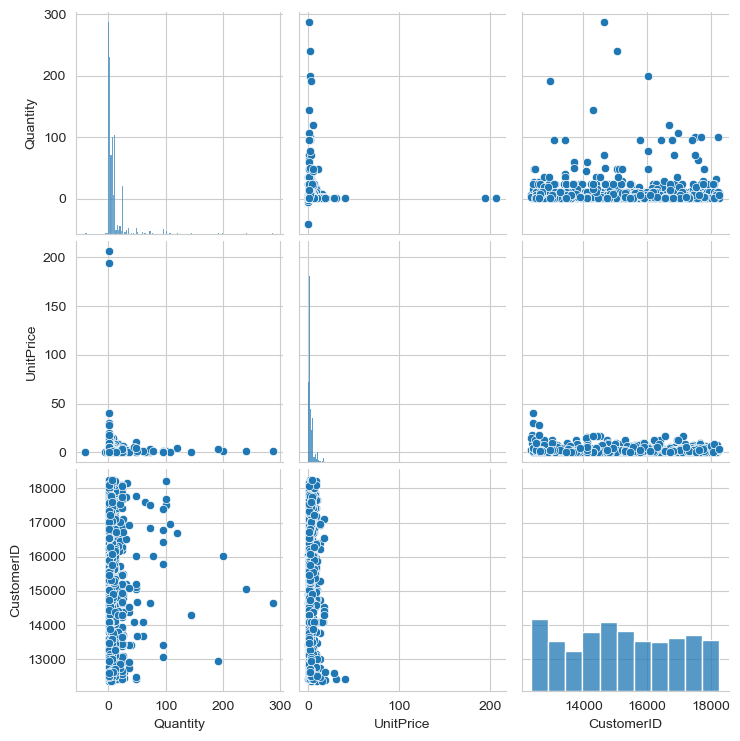

In [317]:
sns.pairplot(df[['Quantity', 'UnitPrice', 'CustomerID']].sample(1000, random_state=42))


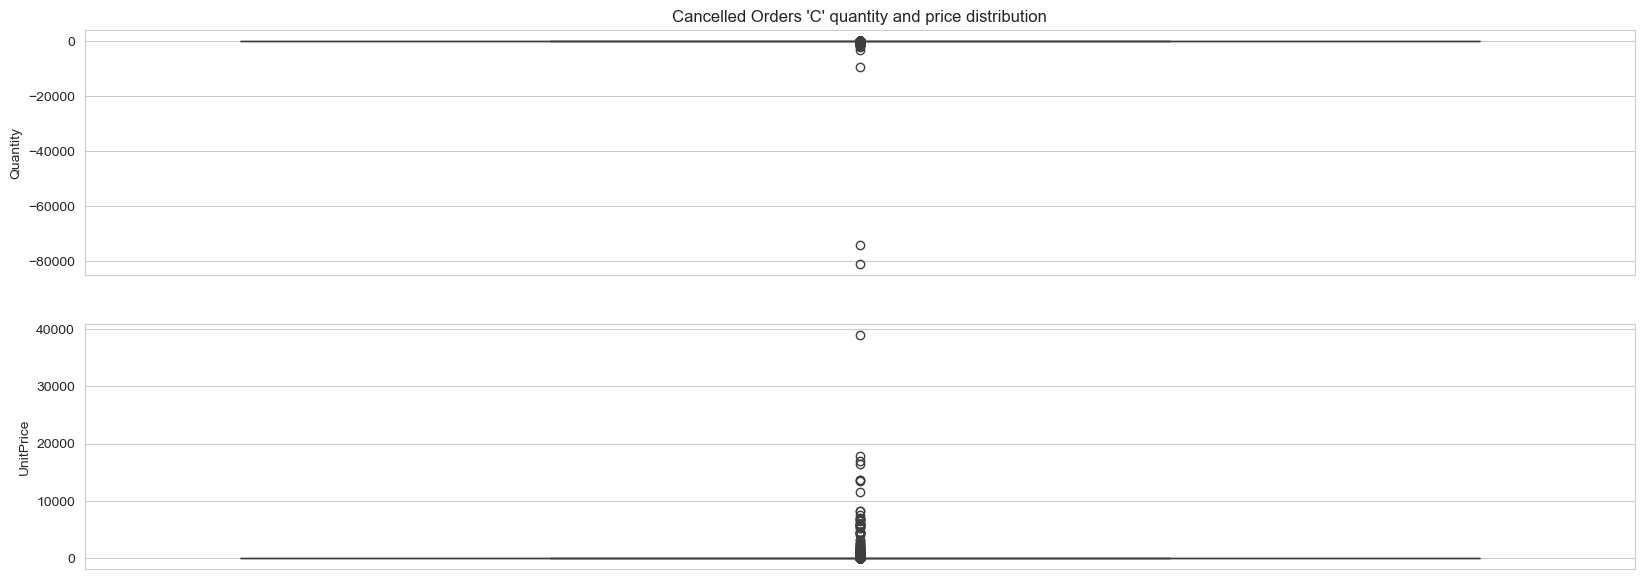

In [187]:
fig,ax = plt.subplots(nrows=2,figsize=(20,7))
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['Quantity'],ax=ax[0])
sns.boxplot(df[(df['InvoiceNo'].str[0]=='c')|(df['InvoiceNo'].str[0]=='C')]['UnitPrice'],ax=ax[1])
ax[0].title.set_text("Cancelled Orders 'C' quantity and price distribution")

In [191]:
neg_qty = df[df["Quantity"]<0]
neg_qty_without_C = neg_qty[neg_qty["InvoiceNo"].str[0]!="C"]
print("Negative Qty without 'C' in InvoiceNo \n Unit Prices: {} \t CustomerIDs: {}".format(neg_qty_without_C["UnitPrice"].unique(),neg_qty_without_C["CustomerID"].unique()))

Negative Qty without 'C' in InvoiceNo 
 Unit Prices: [0.] 	 CustomerIDs: [nan]


In [193]:
def check_hypothesis_cancelled_order(df):
    failed = 0
    passed = 0
    neg_qty = df[df["Quantity"]<0]
    pos_qty = df[~df["Quantity"]<0]
    for ind in neg_qty.index:
        if(neg_qty['CustomerID'][ind]):
            p = pos_qty[
                (pos_qty['CustomerID'] == neg_qty['CustomerID'][ind])&
                (pos_qty['Quantity'] <= abs(neg_qty['Quantity'][ind]))&
                ((pos_qty['InvoiceDate'] - neg_qty['InvoiceDate'][ind]).dt.total_seconds()>=0)
            ]
            if(len(p)==0):
                failed+=1
            else:
                passed+=1
    if(failed>passed):
        print("Hypothesis Rejected!")
        print("Failed Counts:"+str(failed)+" Passed Counts:"+str(passed))
        print("Approximately "+str(int(failed/(failed + passed)*100)) + "% rows didn't satisfy the condition")
    else:
        print("Hypothesis Accepted")
        print("Failed Counts:"+str(failed)+" Passed Counts:"+str(passed))
        print("Approximately "+str(int(passed/(failed + passed)*100)) + "% rows satisfy the condition")

In [195]:
check_hypothesis_cancelled_order(df)

Hypothesis Accepted
Failed Counts:4665 Passed Counts:5959
Approximately 56% rows satisfy the condition


In [197]:
neg_price = df[df["UnitPrice"]<0]
neg_price

InvoiceNo StockCode      Description  Quantity         InvoiceDate  \
299983   A563186         B  Adjust bad debt         1 2011-08-12 14:51:00   
299984   A563187         B  Adjust bad debt         1 2011-08-12 14:52:00   

        UnitPrice  CustomerID         Country  
299983  -11062.06         NaN  United Kingdom  
299984  -11062.06         NaN  United Kingdom

In [199]:
df.drop_duplicates(inplace=True)

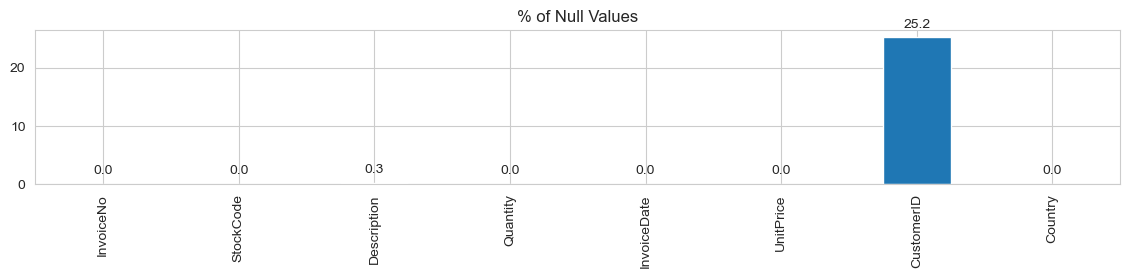

In [201]:
fig,ax = plt.subplots(figsize=(14,2))
((df.isnull().sum() / len(df))*100).plot.bar(ax=ax)
add_value_labels(ax)
ax.set_title('% of Null Values')
plt.show()

In [203]:
x = pd.DataFrame(df.groupby("StockCode")["Description"].value_counts())
y = x.droplevel(level=1).index
y = y[y.duplicated()]
test = df[["StockCode","Description"]]
test = test.drop_duplicates()
test1 = test[test["StockCode"].isin(y)]
test2 = pd.DataFrame(test1.groupby("StockCode")["Description"].value_counts())
test2.head(10)

count
StockCode Description                               
10080     GROOVY CACTUS INFLATABLE                 1
          check                                    1
10133     COLOURING PENCILS BROWN TUBE             1
          damaged                                  1
15058A    BLUE POLKADOT GARDEN PARASOL             1
          wet/rusty                                1
15058C    ICE CREAM DESIGN GARDEN PARASOL          1
          wet/rusty                                1
16008     SMALL FOLDING SCISSOR(POINTED EDGE)      1
          check                                    1

<Axes: xlabel='StockCode'>

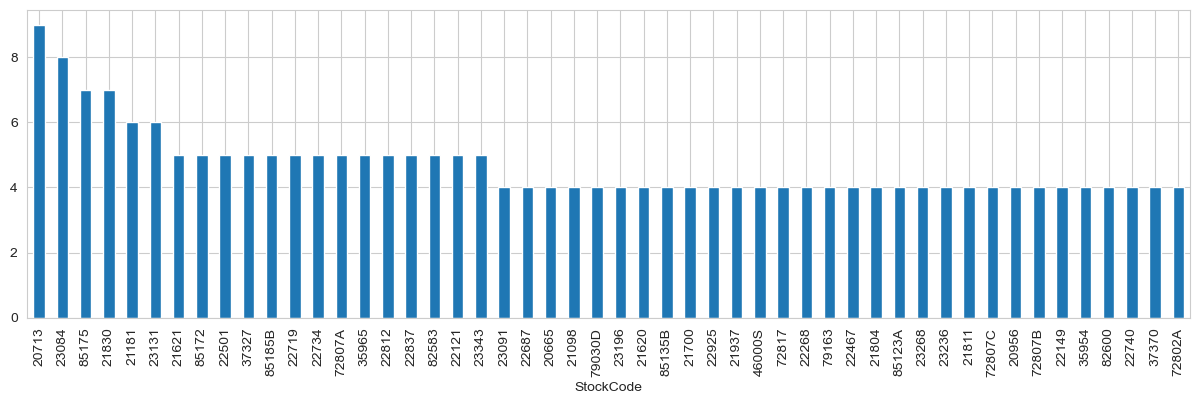

In [205]:
fig, ax = plt.subplots(figsize=(15,4))
grouped = df.groupby("StockCode")['Description'].unique()
grouped_counts = grouped.apply(lambda x: len(x)).sort_values(ascending=False)
grouped_counts.head(50).plot.bar(ax=ax)

In [207]:
df[df["StockCode"]=="20713"]["Description"].unique()

array(['JUMBO BAG OWLS', nan, 'wrongly marked. 23343 in box',
       'wrongly coded-23343', 'found', 'Found', 'wrongly marked 23343',
       'Marked as 23343', 'wrongly coded 23343'], dtype=object)

In [209]:
def get_product_name(x):
    max_upper_count = 0
    product_name = ''
    for i in x:
        if(i==i):  #To Check for NaN
            count = 0
            for letter in i:
                if(letter.isupper()):
                    count = count+1
            if count>max_upper_count:
                max_upper_count = count
                product_name = i
    return product_name

In [211]:
grouped = df.groupby("StockCode")['Description'].unique()
lookup = grouped.apply(get_product_name)
# lookup.to_excel('lookup_product_stockCode.xlsx')

In [213]:
df = df.join(other=lookup, on='StockCode', how='left', rsuffix='ProductName')
df = df.rename(columns={'DescriptionProductName':'ProductName'})

In [215]:
# GETTING SIMILARITY BETWEEN THE Description AND ProductName
# !pip install jellyfish
# import jellyfish
from difflib import SequenceMatcher

des = df['Description']
prod = df['ProductName']
dist = []
for d,p in zip(des, prod):
    try:
        dist.append(SequenceMatcher(None,d,p).ratio())
#         dist.append(float(jellyfish.damerau_levenshtein_distance(d,p)))
    except:
        dist.append(0)

In [216]:
df['dist'] = dist
df[(df['dist']<0.3)&(df['dist']!=0)][['StockCode','Description','ProductName','dist']]

StockCode                 Description  \
22296     46000S                Dotcom sales   
22297     46000M                Dotcom sales   
30555      22734                amazon sales   
39047     85135B                       Found   
42564      22501  reverse 21/5/10 adjustment   
...          ...                         ...   
524369     23406                       CHECK   
524622     22927                      Amazon   
532724     22481                   wet boxes   
535329     21693                    mixed up   
535330     21688                    mixed up   

                               ProductName      dist  
22296         POLYESTER FILLER PAD 40x40cm  0.150000  
22297         POLYESTER FILLER PAD 45x45cm  0.150000  
30555   SET OF 6 RIBBONS VINTAGE CHRISTMAS  0.043478  
39047            BLUE DRAGONFLY HELICOPTER  0.066667  
42564           PICNIC BASKET WICKER LARGE  0.076923  
...                                    ...       ...  
524369          HOME SWEET HOME KEY HOLDER  0.193548  
524622      GREEN GIANT GARDEN THERMOMETER  0.055556  
532724      BLACK TEA TOWEL CLASSIC DESIGN  0.051282  
535329    SMALL HAMMERED SILVER CANDLEPOT   0.050000  
535330      SILVER PLATE CANDLE BOWL SMALL  0.052632  

[196 rows x 4 columns]

In [219]:
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

<Axes: ylabel='ProductName'>

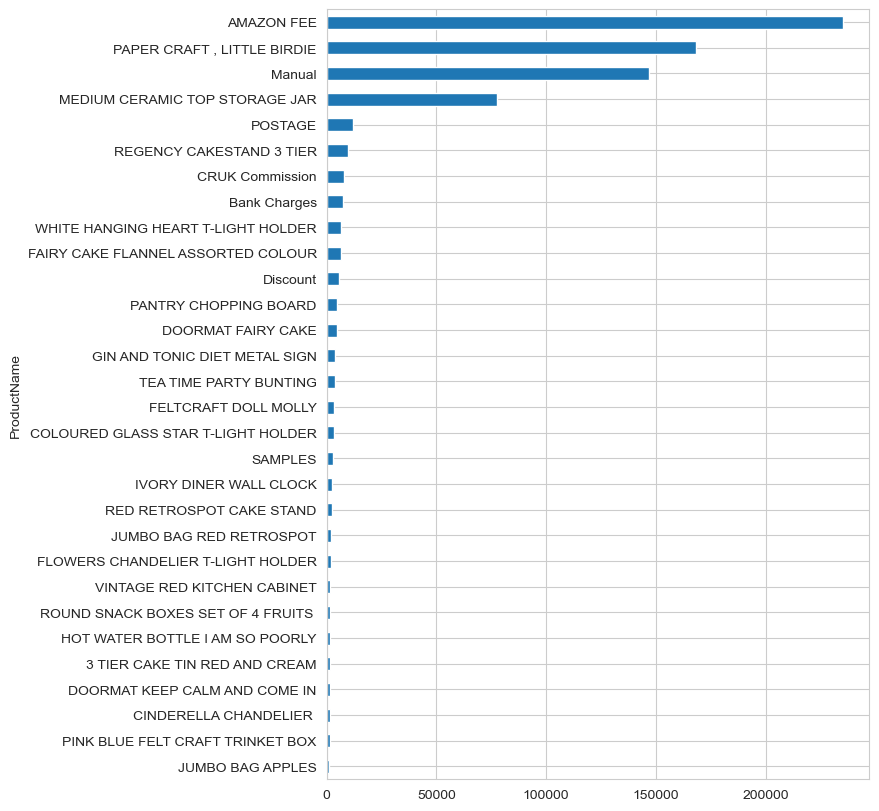

In [221]:
fig, ax = plt.subplots(figsize=(7,10))
neg_qty = df[df["Quantity"]<0]
neg_qty["TotalPrice"] = abs(neg_qty["TotalPrice"])
x = neg_qty[["ProductName","TotalPrice"]]
x.groupby("ProductName")["TotalPrice"].sum().sort_values(ascending=True).tail(30).plot.barh(ax=ax)

In [223]:
cancelled_df = df[df['InvoiceNo'].str[0]=='C']
df = df[~(df['InvoiceNo'].str[0]=='C')]
cancelled_df = cancelled_df.reset_index(drop=True)

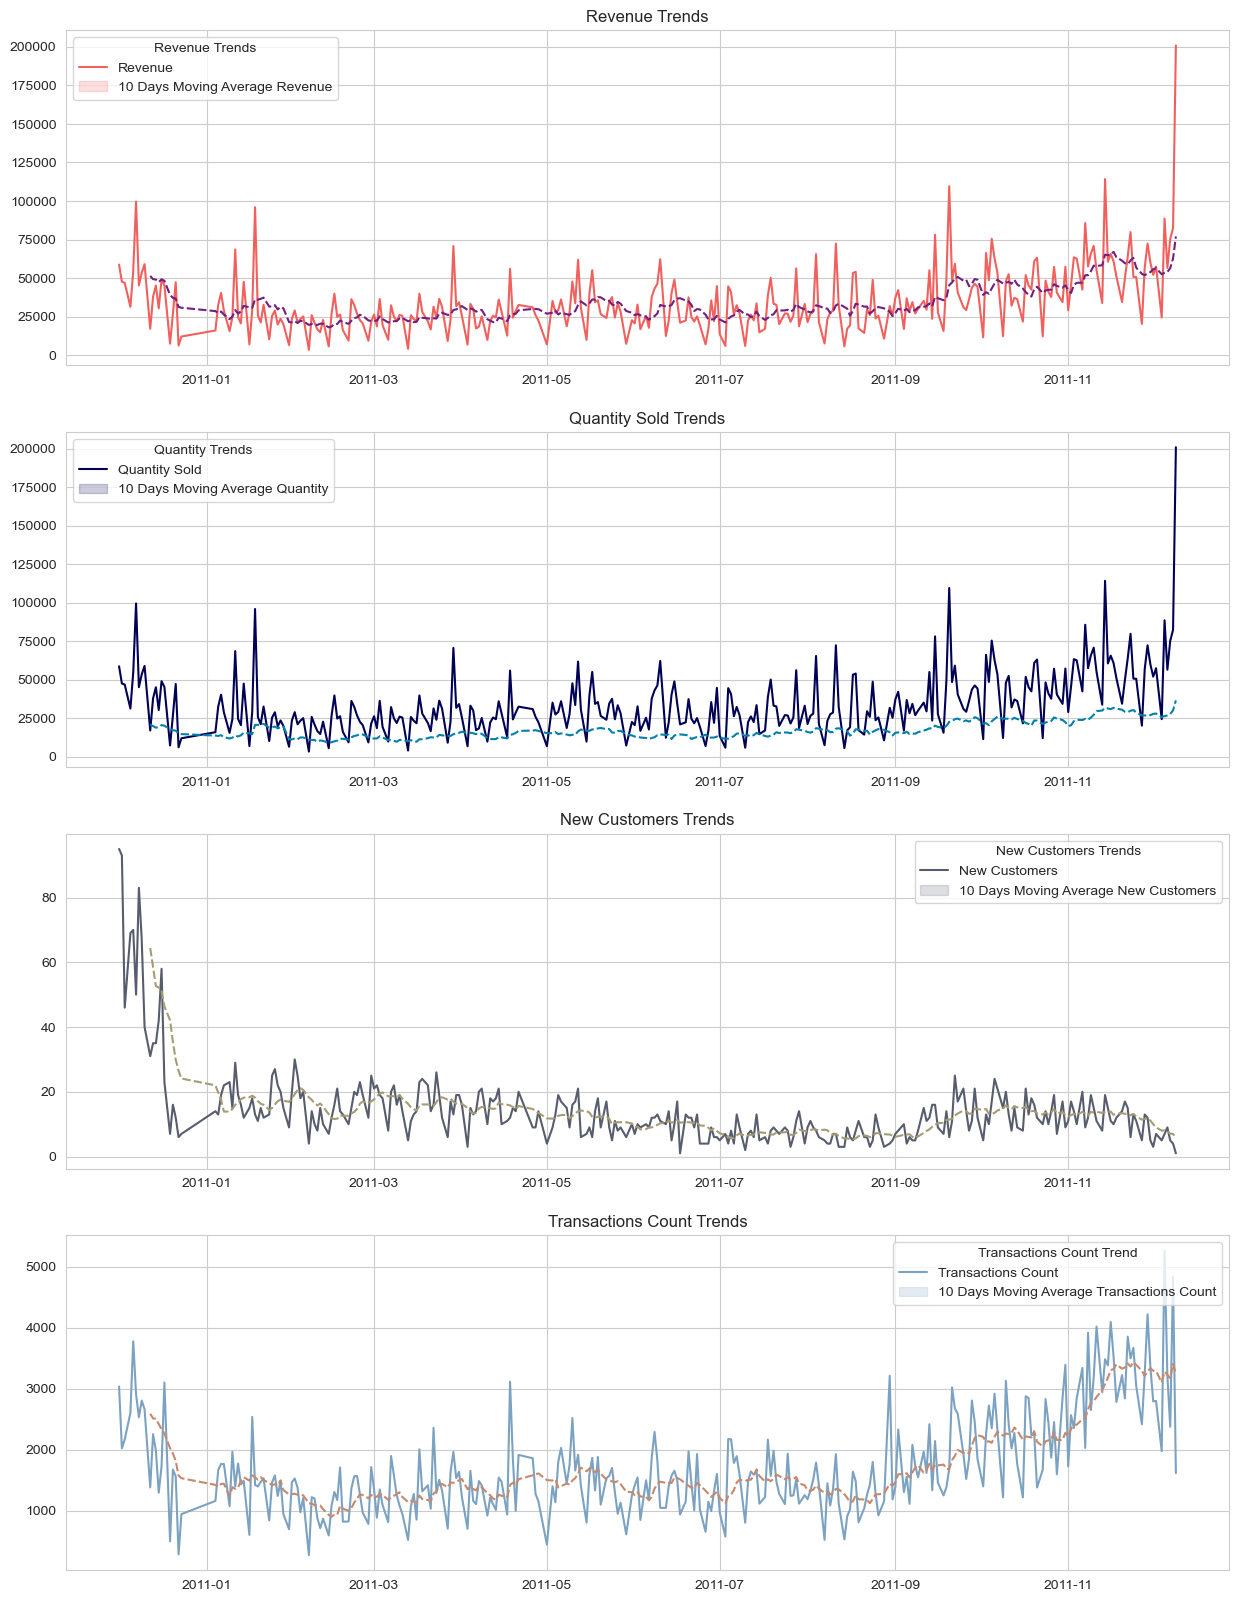

In [225]:
fig, ax = plt.subplots(nrows=4, ncols=1,figsize=(15,20))
rev = df[df['TotalPrice']>=0]
rev['TransactionsCount'] = 1
rev = rev.groupby(rev['InvoiceDate'].dt.date).agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count',
                                                  'TransactionsCount':'sum'})
rev['10 Days Moving Average Revenue'] = rev['TotalPrice'].rolling(10).mean()
rev['10 Days Moving Average Quantity'] = rev['Quantity'].rolling(10).mean()
rev['10 Days Moving Transactions Count'] = rev['TransactionsCount'].rolling(10).mean()
cust = df.groupby('CustomerID').first().reset_index()[['CustomerID','InvoiceDate']]
cust = cust.groupby(cust.InvoiceDate.dt.date).agg({'CustomerID':'count'})
cust['10 Days Moving Average Quantity'] = cust['CustomerID'].rolling(10).mean()

sns.set_style("whitegrid")
sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Revenue']], palette='magma_r', linewidth=1.5, ax=ax[0],legend=False)
ax[0].legend(title='Revenue Trends', loc='upper left', labels=['Revenue', '10 Days Moving Average Revenue'])
ax[0].title.set_text('Revenue Trends')
ax[0].set_xlabel('')

sns.lineplot(data=rev[['TotalPrice','10 Days Moving Average Quantity']], palette='ocean', linewidth=1.5, ax=ax[1])
ax[1].legend(title='Quantity Trends', loc='upper left', labels=['Quantity Sold', '10 Days Moving Average Quantity'])
ax[1].title.set_text('Quantity Sold Trends')
ax[1].set_xlabel('')

sns.lineplot(data=cust, palette='cividis', linewidth=1.5, ax=ax[2])
ax[2].legend(title='New Customers Trends', loc='upper right', labels=['New Customers', '10 Days Moving Average New Customers'])
ax[2].title.set_text('New Customers Trends')
ax[2].set_xlabel('')

sns.lineplot(data=rev[['TransactionsCount','10 Days Moving Transactions Count']], palette='twilight_shifted', linewidth=1.5, ax=ax[3])
ax[3].legend(title='Transactions Count Trend', loc='upper right', labels=['Transactions Count', '10 Days Moving Average Transactions Count'])
ax[3].title.set_text('Transactions Count Trends')
ax[3].set_xlabel('')

plt.show()

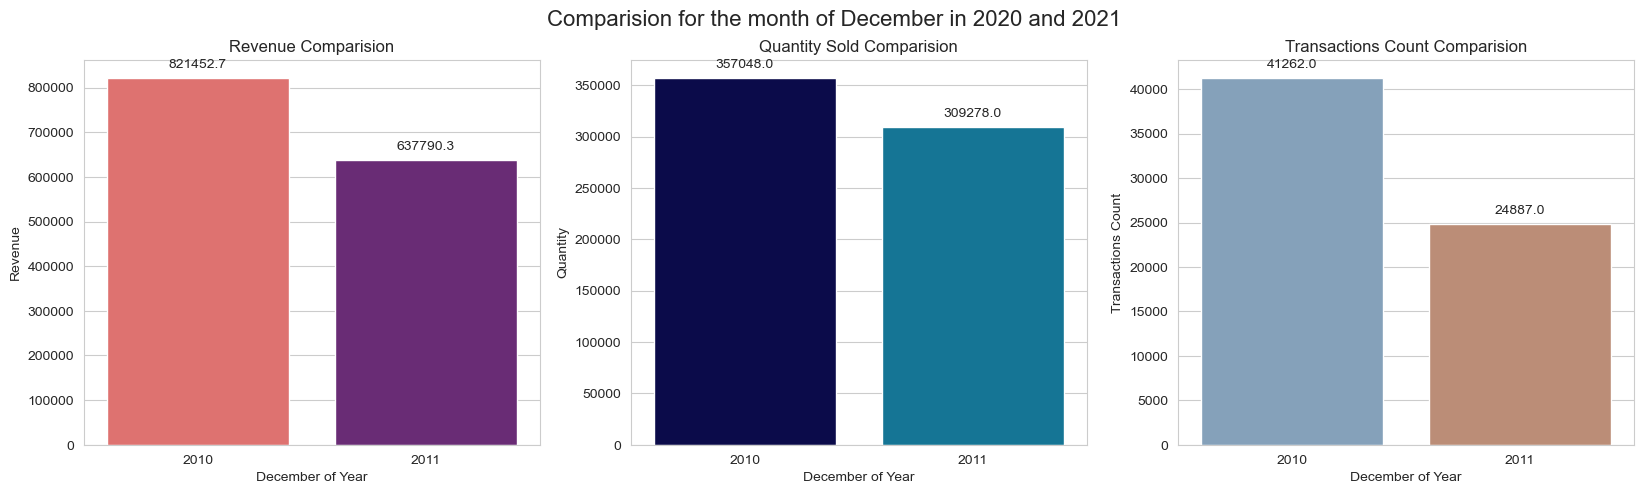

In [227]:
sales_comp = df[(df['InvoiceDate'].dt.month==12)&(df['TotalPrice']>=0)][['InvoiceDate','TotalPrice','Quantity']]
sales_comp['Transactions Count'] = 1
sales_comp = sales_comp.groupby(sales_comp['InvoiceDate'].dt.year)[['TotalPrice','Quantity','Transactions Count']].sum()
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(20,5))

sns.set_style("whitegrid")
sns.barplot(data=sales_comp, x=sales_comp.index, y='TotalPrice', palette='magma_r', ax=ax[0])
ax[0].title.set_text('Revenue Comparision')
ax[0].set_ylabel('Revenue')
ax[0].set_xlabel('December of Year')
add_value_labels(ax[0])

sns.barplot(data=sales_comp, x=sales_comp.index, y='Quantity',  palette='ocean', ax=ax[1])
ax[1].title.set_text('Quantity Sold Comparision')
add_value_labels(ax[1])
ax[1].set_xlabel('December of Year')

sns.barplot(data=sales_comp, x=sales_comp.index, y='Transactions Count',  palette='twilight_shifted', ax=ax[2])
ax[2].title.set_text('Transactions Count Comparision')
add_value_labels(ax[2])
ax[2].set_xlabel('December of Year')

fig.suptitle('Comparision for the month of December in 2020 and 2021',fontsize=16)

plt.show()

In [229]:
print("Sales Revenue Difference: {:2.2f}% decline in revenue from 2010 \nSales Quantity Difference: {:2.2f}% decline in quantity from 2010".format(
((sales_comp['TotalPrice'][2010] - sales_comp['TotalPrice'][2011]) / sales_comp['TotalPrice'][2010])*100,
    ((sales_comp['Quantity'][2010] - sales_comp['Quantity'][2011]) / sales_comp['Quantity'][2010])*100
))

Sales Revenue Difference: 22.36% decline in revenue from 2010 
Sales Quantity Difference: 13.38% decline in quantity from 2010


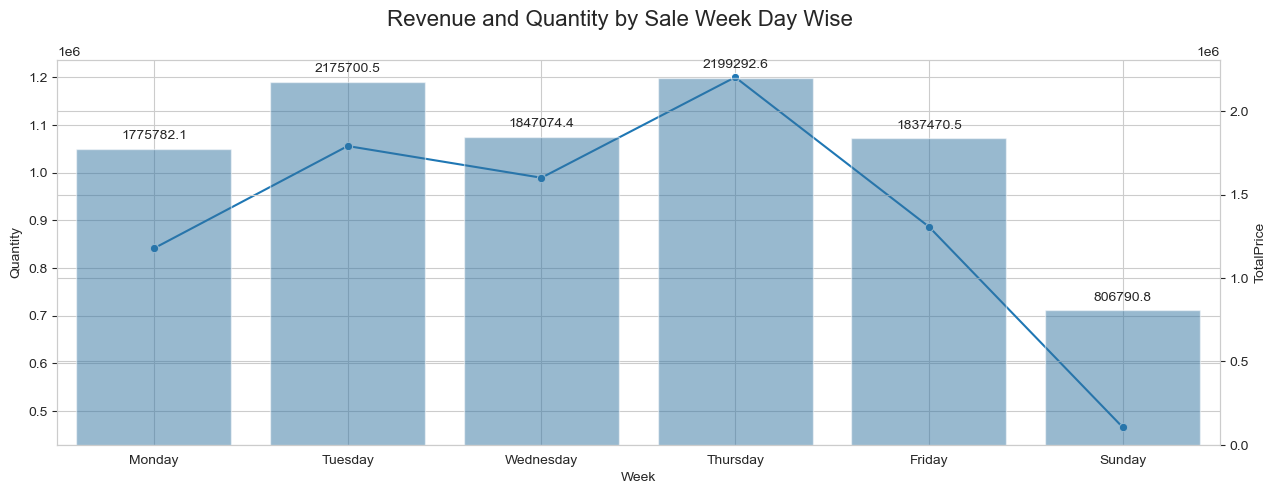

In [231]:

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15,5))
sns.set_style("whitegrid")

week = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
week = week.groupby(week['InvoiceDate'].dt.weekday)[['TotalPrice','Quantity']].sum()
week = week.reset_index()
week['Week'] = week['InvoiceDate'].apply(lambda x: calendar.day_name[x])

sns.lineplot(data = week, x=week.Week, y='Quantity', marker='o', sort = False, ax=ax)
ax2 = ax.twinx()
sns.barplot(data = week, x=week.Week, y='TotalPrice', alpha=0.5, ax=ax2)
fig.suptitle('Revenue and Quantity by Sale Week Day Wise',fontsize=16)
add_value_labels(ax2)

plt.show()

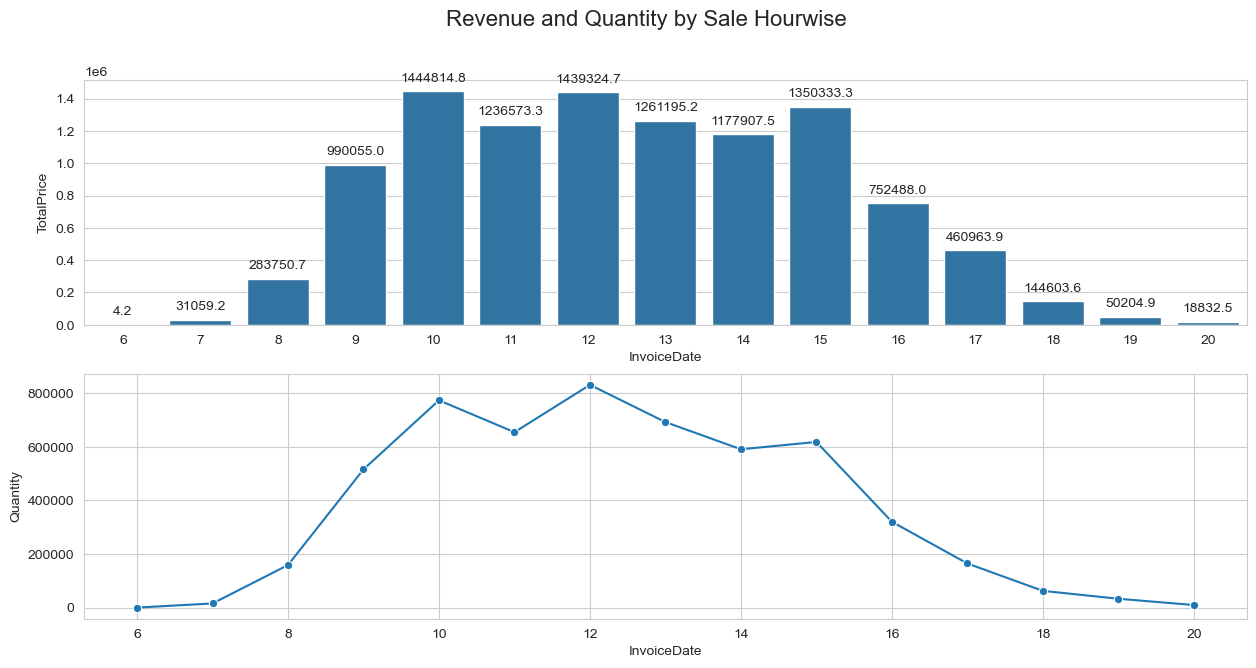

In [233]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

day = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
day = day.groupby(day['InvoiceDate'].dt.hour)[['TotalPrice','Quantity']].sum()

sns.barplot(data = day, x=day.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = day, x=day.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Hourwise',fontsize=16)
add_value_labels(ax[0])
plt.show()

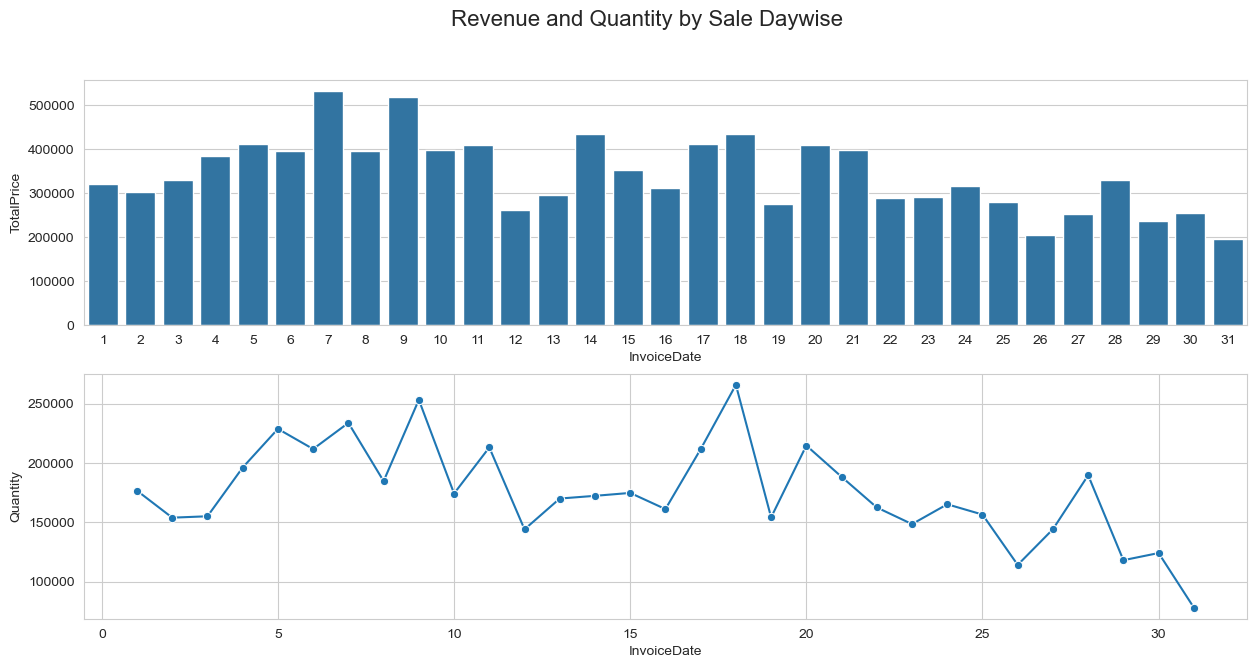

In [235]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

date = df[df['TotalPrice']>=0][['InvoiceDate','TotalPrice','Quantity']]
date = date.groupby(date['InvoiceDate'].dt.day)[['TotalPrice','Quantity']].sum()

sns.barplot(data = date, x=date.index, y='TotalPrice', alpha=1, ax=ax[0])
sns.lineplot(data = date, x=date.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Daywise',fontsize=16)

plt.show()

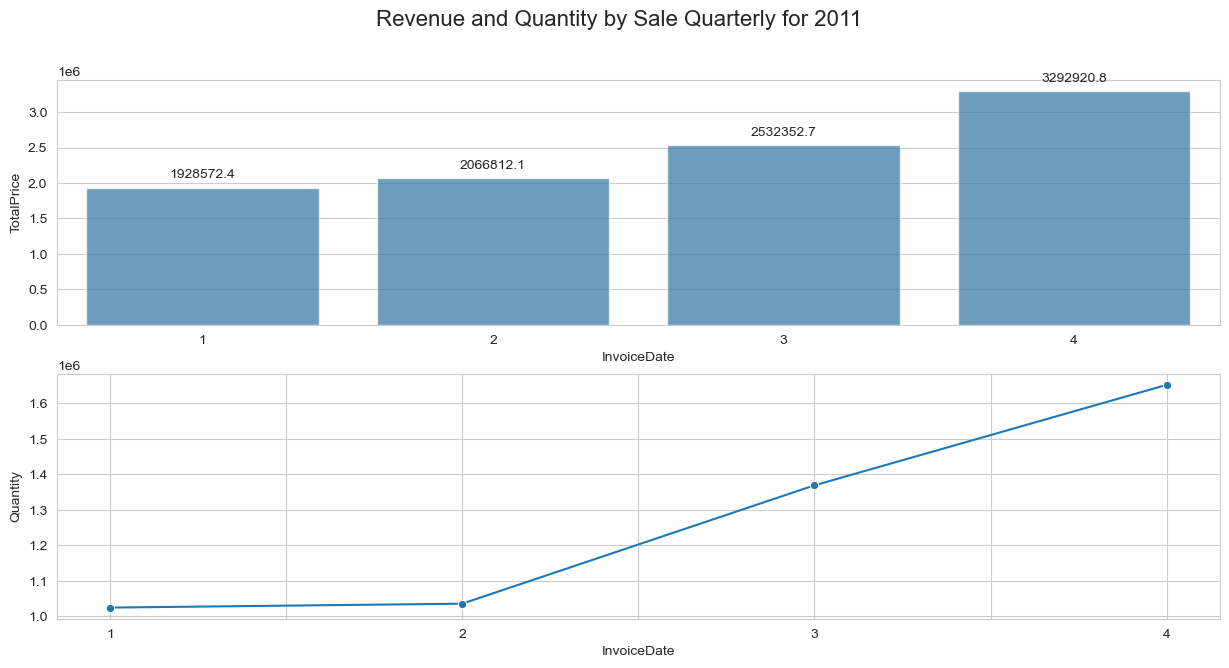

In [237]:
fig, ax = plt.subplots(nrows=2, ncols=1,figsize=(15,7))
sns.set_style("whitegrid")

q = df[(df['TotalPrice']>=0)&(df['InvoiceDate'].dt.year==2011)][['InvoiceDate','TotalPrice','Quantity']]
q = q.groupby(q['InvoiceDate'].dt.quarter)[['TotalPrice','Quantity']].sum()

sns.barplot(data = q, x=q.index, y='TotalPrice', alpha=0.7, ax=ax[0])
sns.lineplot(data = q, x=q.index, y='Quantity', marker='o', sort = False, ax=ax[1])
fig.suptitle('Revenue and Quantity by Sale Quarterly for 2011',fontsize=16)
add_value_labels(ax[0])
ax[1].set_xticklabels(['',1,'',2,'',3,'',4])
plt.show()

In [239]:
reg = df[df['TotalPrice']>=0].groupby('Country').agg({'TotalPrice':'sum',
                                                  'Quantity': 'sum',
                                                  'CustomerID': 'count'})

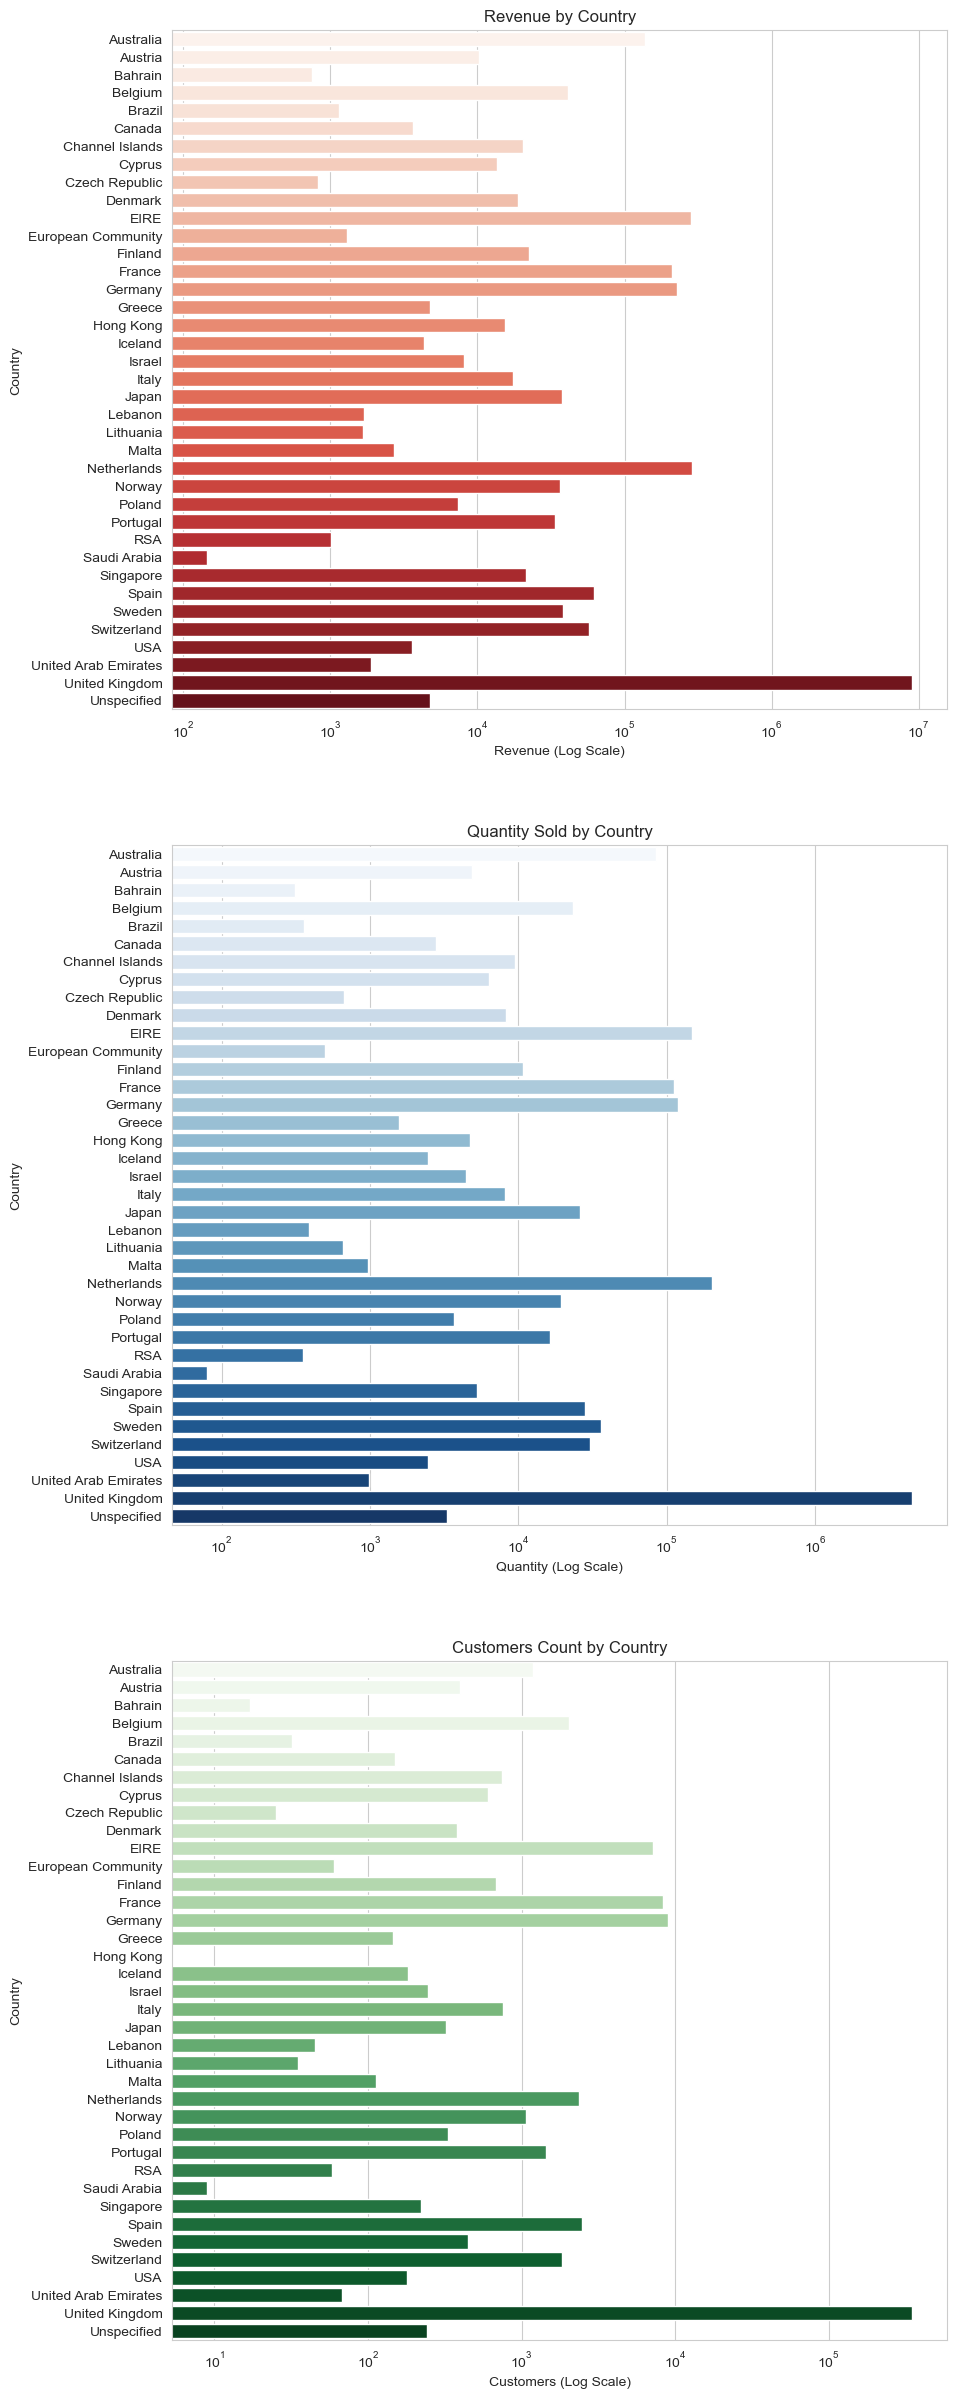

In [241]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,30))
g1 = sns.barplot(x=reg['TotalPrice'], y=reg.index, alpha=1, ax=ax[0],palette='Reds', orient='h')
g2 = sns.barplot(x=reg['Quantity'], y=reg.index, alpha=1, ax=ax[1], palette='Blues',orient='h')
g3 = sns.barplot(x=reg['CustomerID'], y=reg.index, alpha=1, ax=ax[2], palette='Greens', orient='h')
ax[2].title.set_text('Customers Count by Country')
ax[2].set_xlabel("Customers (Log Scale)")
ax[1].title.set_text('Quantity Sold by Country')
ax[1].set_xlabel("Quantity (Log Scale)")
ax[0].title.set_text('Revenue by Country')
ax[0].set_xlabel("Revenue (Log Scale)")
g1.set_xscale("log")
g2.set_xscale("log")
g3.set_xscale("log")
plt.show()

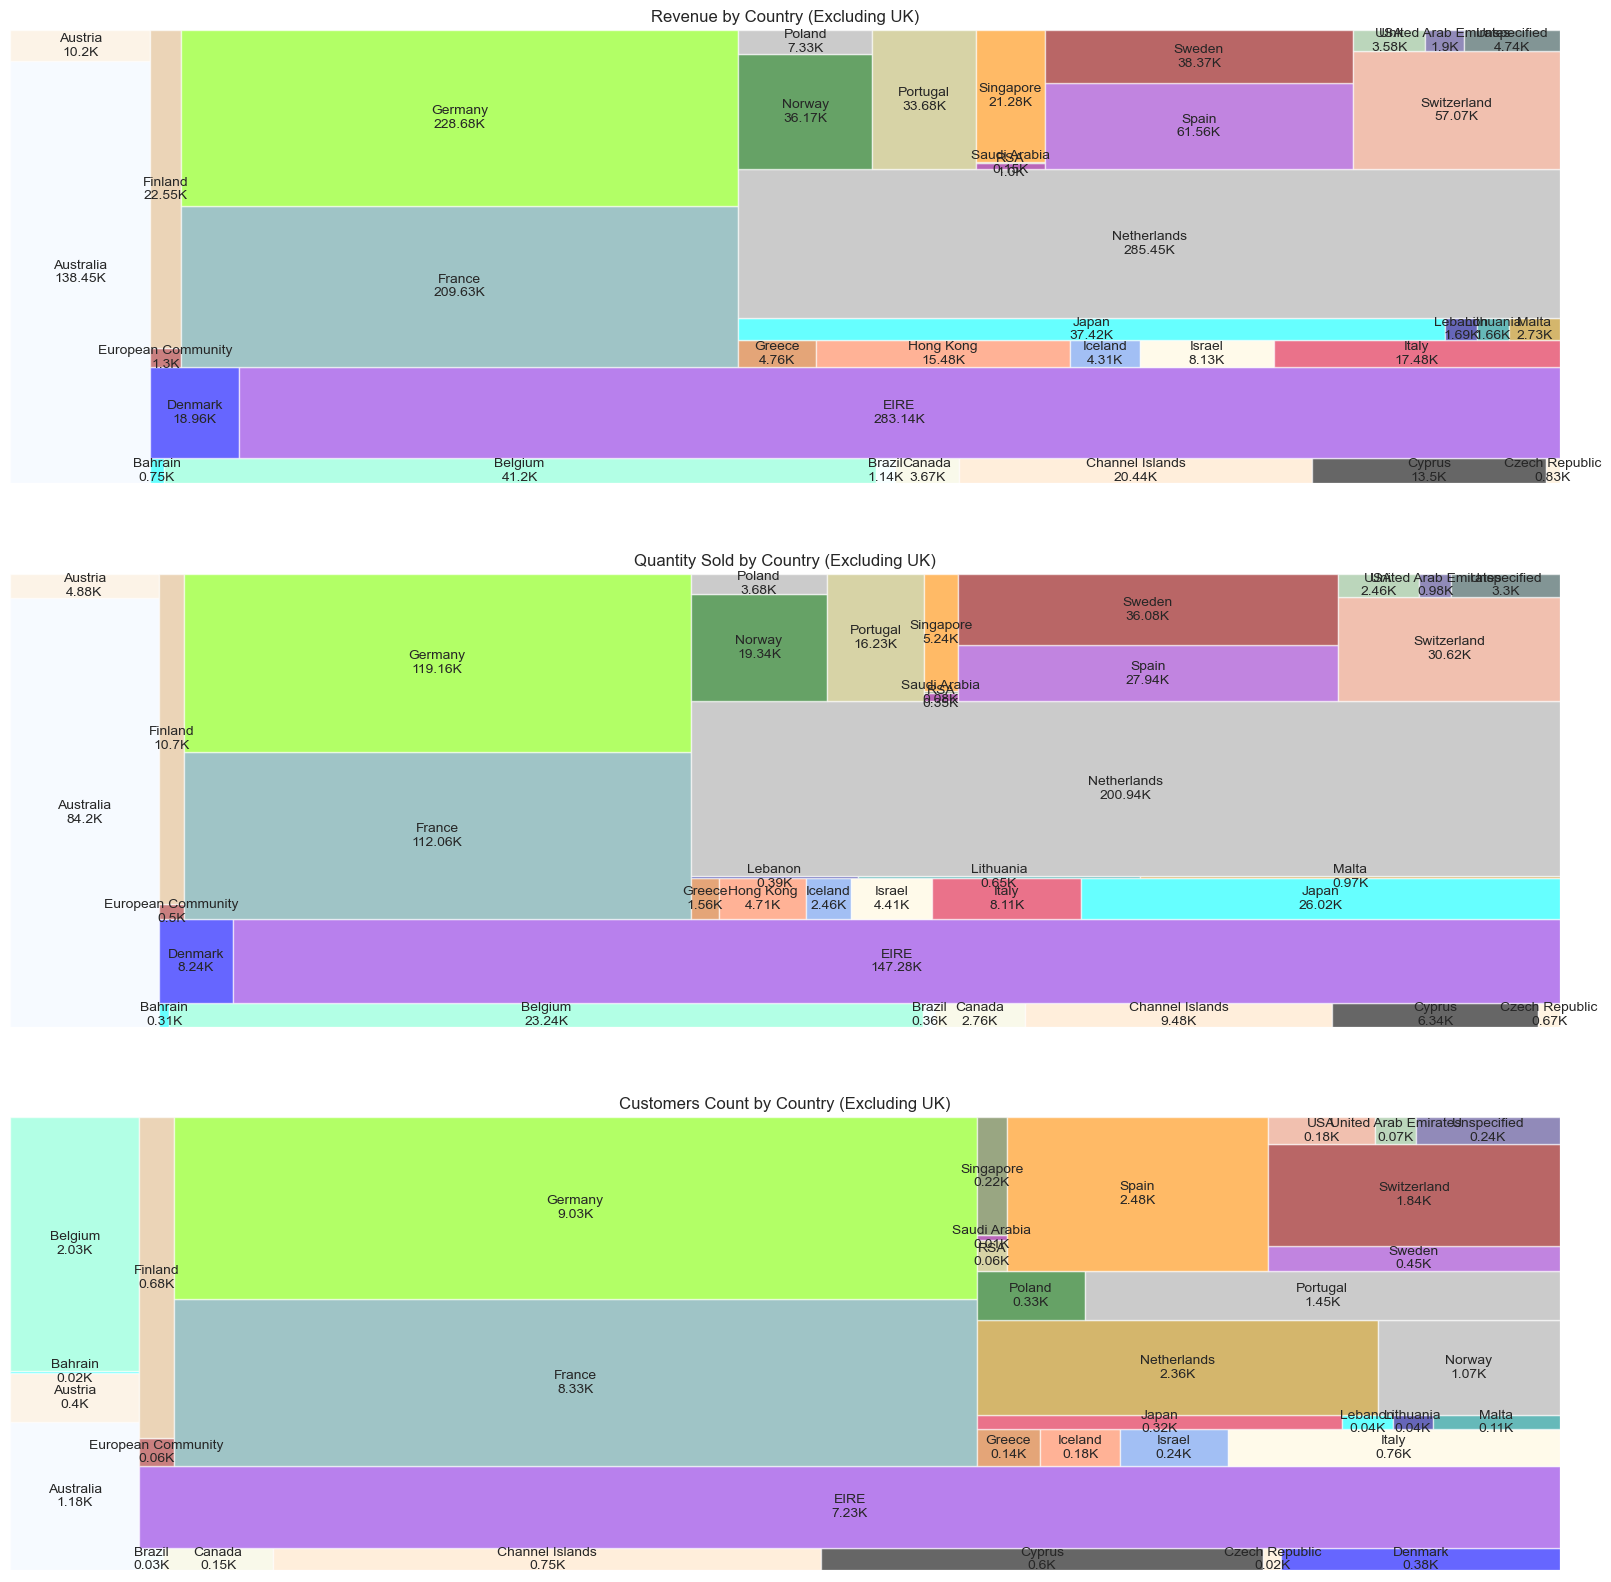

In [242]:
reg = reg[reg.index!='United Kingdom']
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
# Change color
squarify.plot(sizes=reg['TotalPrice'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['TotalPrice']/1000).round(2))], alpha=.6, ax=ax[0], color=mcolors.CSS4_COLORS )
ax[0].title.set_text('Revenue by Country (Excluding UK)')
squarify.plot(sizes=reg['Quantity'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(reg.index,(reg['Quantity']/1000).round(2))], alpha=.6, ax=ax[1], color=mcolors.CSS4_COLORS )
ax[1].title.set_text('Quantity Sold by Country (Excluding UK)')
r1 = reg[reg['CustomerID']!=0]
squarify.plot(sizes=r1['CustomerID'], label=[str(x)+'\n'+str(y)+'K' for x,y in zip(r1.index,(r1['CustomerID']/1000).round(2))], alpha=.6, ax=ax[2], color=mcolors.CSS4_COLORS )
ax[2].title.set_text('Customers Count by Country (Excluding UK)')
ax[0].axis('off')
ax[1].axis('off')
ax[2].axis('off')
plt.show()

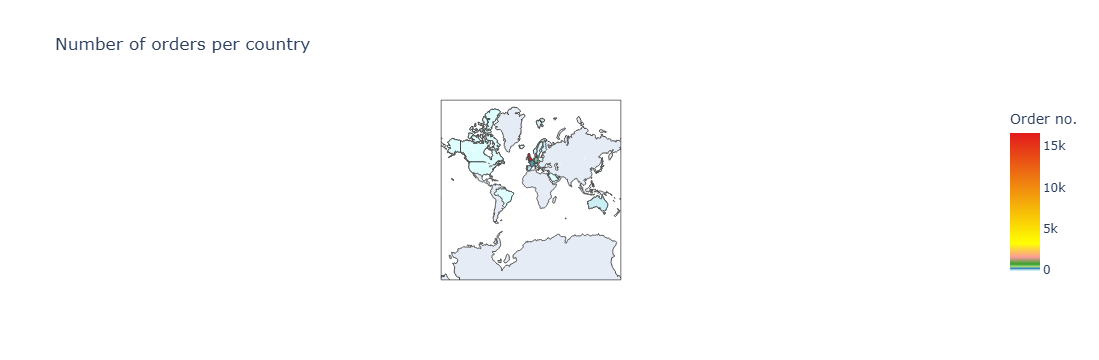

In [245]:
## https://www.kaggle.com/fabiendaniel/customer-segmentation


import plotly.graph_objs as go
import warnings
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

temp = df[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()

data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order no.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [247]:
lastdate = datetime(2012,1,1)
cleaned_dataset = df[df['TotalPrice']>=0]
recent = (lastdate - cleaned_dataset.groupby("CustomerID")["InvoiceDate"].last()).dt.days
frequent = cleaned_dataset.groupby("CustomerID")["InvoiceDate"].count()
monetary = cleaned_dataset.groupby("CustomerID")["TotalPrice"].sum()

In [249]:
recent_quantile = recent.quantile(q=[0.25,0.5,0.75])
recent_quantile

0.25     39.0
0.50     72.0
0.75    163.5
Name: InvoiceDate, dtype: float64

In [251]:
frequent_quantile = frequent.quantile(q=[0.25,0.5,0.75])
frequent_quantile

0.25    17.0
0.50    41.0
0.75    98.0
Name: InvoiceDate, dtype: float64

In [253]:
monetary_quantile = monetary.quantile(q=[0.25,0.5,0.75])
monetary_quantile

0.25     306.455
0.50     668.560
0.75    1660.315
Name: TotalPrice, dtype: float64

In [255]:
rfm = pd.DataFrame(data=[recent,frequent,monetary])
rfm = rfm.transpose()
rfm.columns = ["recent","frequent","monetary"]
rfm

recent  frequent  monetary
CustomerID                            
12346.0      347.0       1.0  77183.60
12347.0       24.0     182.0   4310.00
12348.0       97.0      31.0   1797.24
12349.0       40.0      73.0   1757.55
12350.0      332.0      17.0    334.40
...            ...       ...       ...
18280.0      299.0      10.0    180.60
18281.0      202.0       7.0     80.82
18282.0       29.0      12.0    178.05
18283.0       25.0     721.0   2045.53
18287.0       64.0      70.0   1837.28

[4339 rows x 3 columns]

In [257]:
def get_kmeans_wcss(data, n_limit=15):
    wcss = [] #Within cluster sum of squares (WCSS)
    for i in range(1,n_limit):
        km = KMeans(init='k-means++', n_clusters=i, n_init=10)
        km.fit(data)
        wcss.append(km.inertia_)
    plt.title("Elbow Method")
    plt.plot(range(1, n_limit), wcss)
    plt.xlabel("Number of clusters")
    plt.ylabel("WCSS")
    return wcss

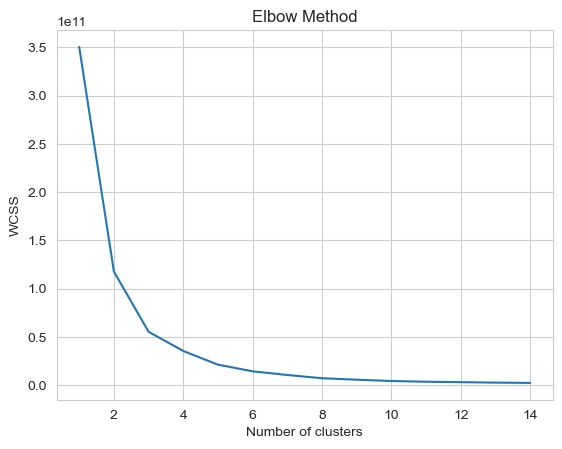

In [259]:
_ = get_kmeans_wcss(rfm, n_limit=15)

In [260]:
kmeans = KMeans(n_clusters=3, init = "k-means++", random_state=42)
clustered_cust = kmeans.fit_predict(rfm)

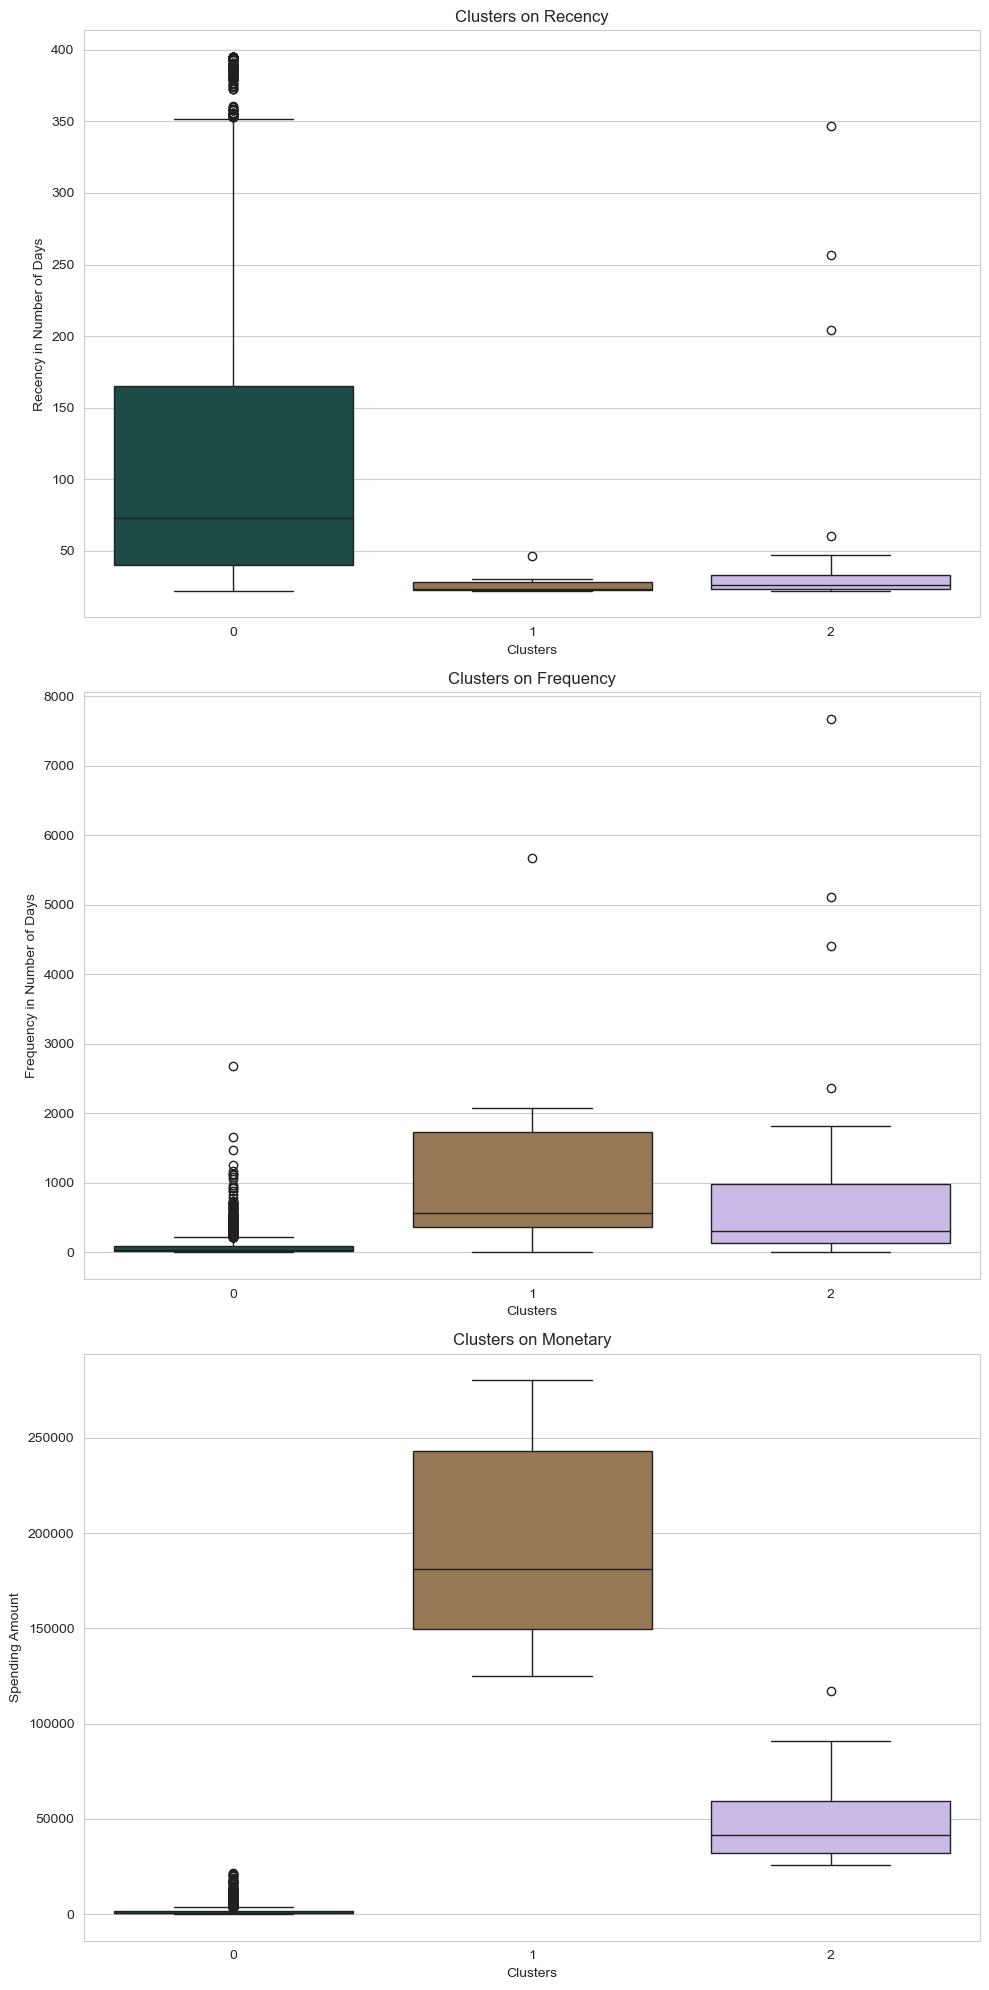

In [263]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

# Boxplot for Recency
sns.boxplot(x=clustered_cust, y=recent, palette="cubehelix", ax=ax[0])
ax[0].set(xlabel="Clusters", ylabel="Recency in Number of Days")
ax[0].set_title('Clusters on Recency')

# Boxplot for Frequency
sns.boxplot(x=clustered_cust, y=frequent, palette="cubehelix", ax=ax[1])
ax[1].set(xlabel="Clusters", ylabel="Frequency in Number of Days")
ax[1].set_title('Clusters on Frequency')

# Boxplot for Monetary
sns.boxplot(x=clustered_cust, y=monetary, palette="cubehelix", ax=ax[2])
ax[2].set(xlabel="Clusters", ylabel="Spending Amount")
ax[2].set_title('Clusters on Monetary')

plt.tight_layout()
plt.show()


In [265]:
rfm['Clusters'] = clustered_cust
rfm.Clusters.value_counts()

Clusters
0    4301
2      32
1       6
Name: count, dtype: int64

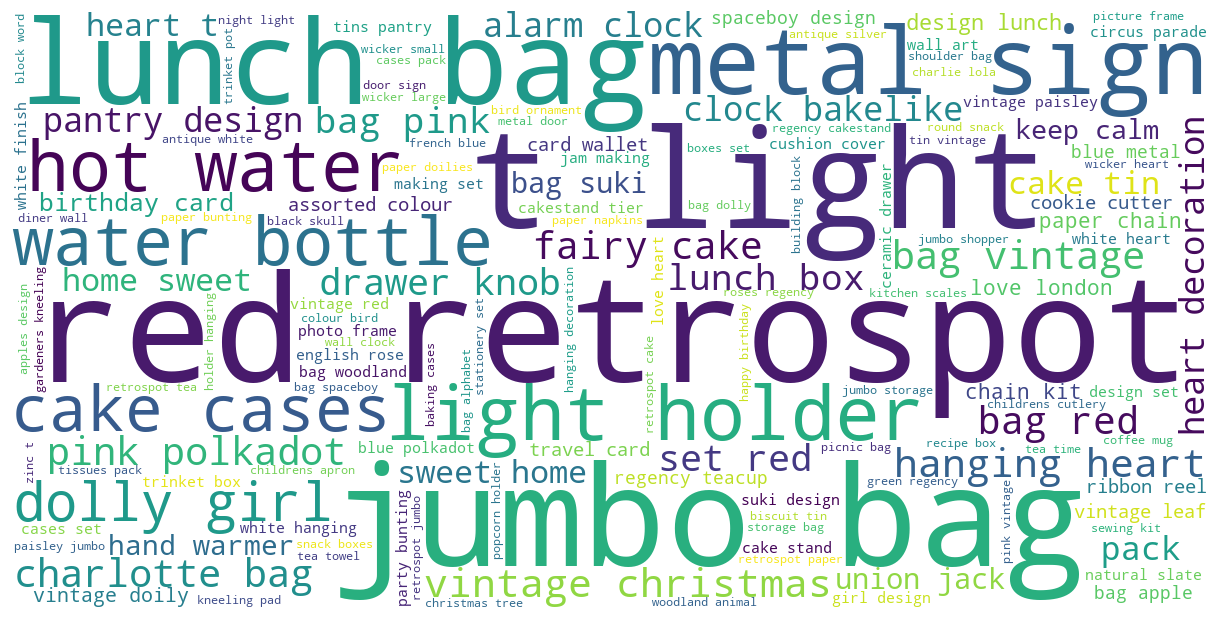

In [267]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Combine all product descriptions into one big string efficiently
comment_words = ' '.join(
    df['Description']
    .dropna()  # Drop missing descriptions
    .astype(str)
    .str.lower()  # Lowercase
)

# Define stopwords
stopwords = set(STOPWORDS)

# Generate WordCloud
wordcloud = WordCloud(
    width=1200, height=600,
    background_color='white',
    stopwords=stopwords,
    min_font_size=10
).generate(comment_words)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


In [269]:
df['HolidaySeason'] = 0
df.loc[df['InvoiceDate'].dt.month.isin([9,10,11]), 'HolidaySeason'] = 1

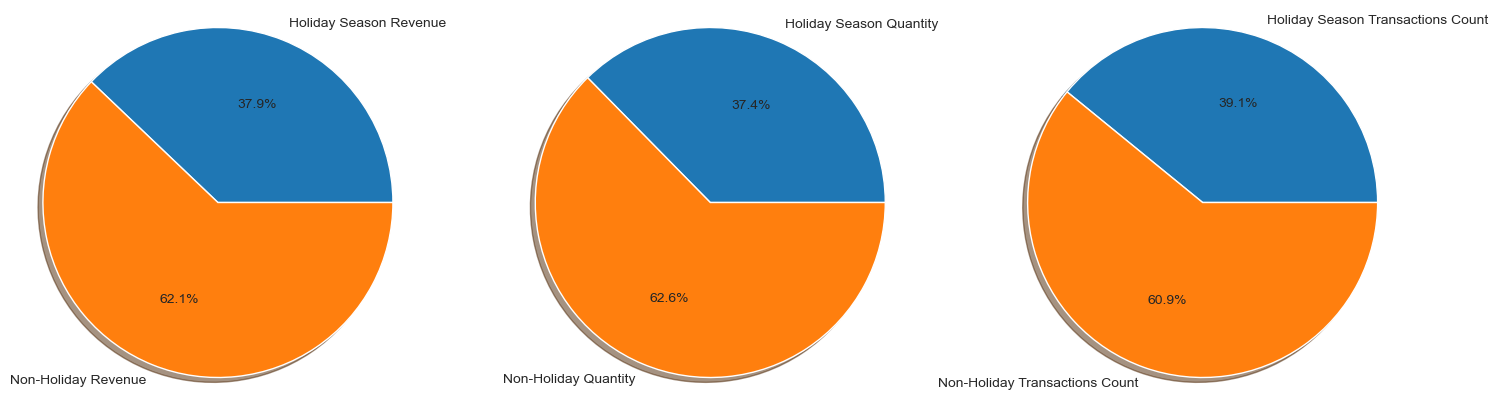

In [271]:
d = df[df['InvoiceDate'].dt.year==2011]
d['Transactions Count'] = 1
labels0 = ['Holiday Season Revenue', 'Non-Holiday Revenue']
sizes0 = [d[d['HolidaySeason']==1]['TotalPrice'].sum(),
         d[d['HolidaySeason']==0]['TotalPrice'].sum()
        ]

labels1 = ['Holiday Season Quantity', 'Non-Holiday Quantity']
sizes1 = [d[d['HolidaySeason']==1]['Quantity'].sum(),
         d[d['HolidaySeason']==0]['Quantity'].sum()
        ]

labels2 = ['Holiday Season Transactions Count', 'Non-Holiday Transactions Count']
sizes2 = [d[d['HolidaySeason']==1]['Transactions Count'].sum(),
         d[d['HolidaySeason']==0]['Transactions Count'].sum()
        ]

fig1, ax = plt.subplots(ncols=3,figsize=(18,5))
ax[0].pie(sizes0, labels=labels0, autopct='%1.1f%%', shadow=True)
ax[0].axis('equal')
ax[1].pie(sizes1, labels=labels1, autopct='%1.1f%%', shadow=True)
ax[1].axis('equal')
ax[2].pie(sizes2, labels=labels2, autopct='%1.1f%%', shadow=True)
ax[2].axis('equal')
plt.show()

In [273]:
df['Transactions Count'] = 1
l1 = df[df['HolidaySeason']==1].groupby('StockCode')['Transactions Count'].sum()
l2 = df[df['HolidaySeason']==0].groupby('StockCode')['Transactions Count'].sum()
x = pd.DataFrame(data=[l1,l2]).T
x.columns = ['Season','Off-Season']
x = x.fillna(0)
x = x.reset_index()

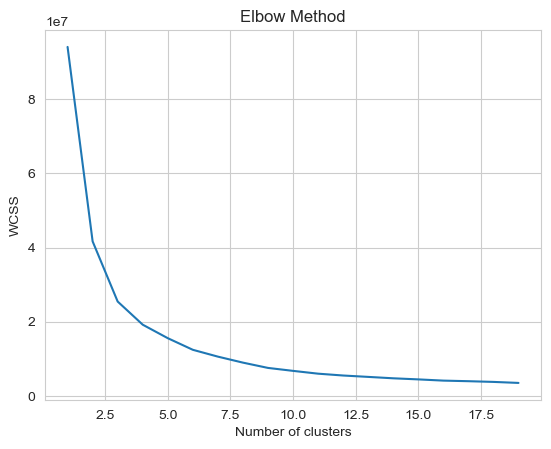

In [275]:
_ = get_kmeans_wcss(x[['Season','Off-Season']], n_limit=20)

In [277]:
kmeans = KMeans(n_clusters=10, init = "k-means++", random_state=100)
clustered_cust = kmeans.fit_predict(x[['Season','Off-Season']])
x['cluster'] = clustered_cust

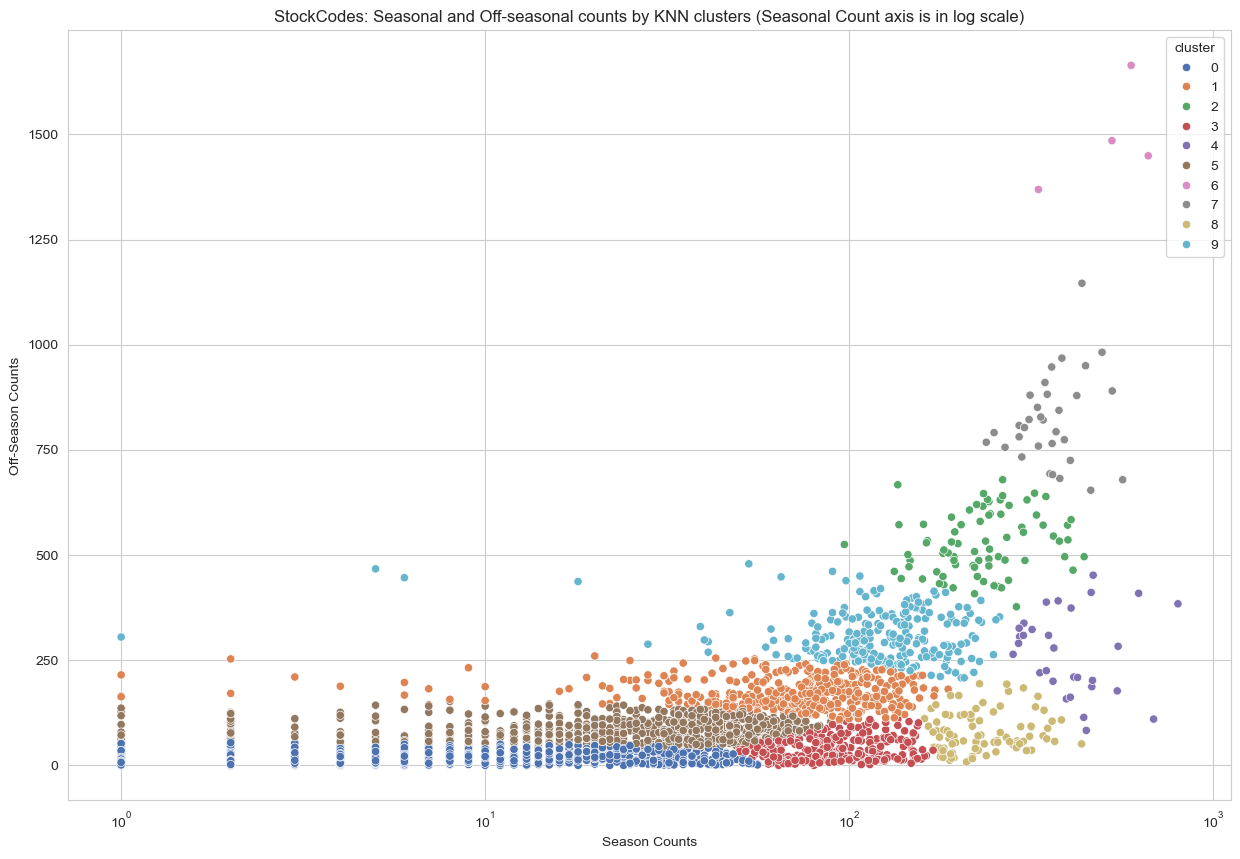

In [279]:
plt.figure(figsize=(15,10))

g1 = sns.scatterplot(
    data=x,
    x="Season",
    y="Off-Season",
    hue="cluster",
    palette="deep"
)

g1.set_xscale("log")
plt.xlabel('Season Counts')
plt.title('StockCodes: Seasonal and Off-seasonal counts by KNN clusters (Seasonal Count axis is in log scale)')
plt.ylabel('Off-Season Counts')
plt.show()


In [281]:
# Step 1: Get StockCodes from cluster 8
stockcodes_cluster_8 = x[x['cluster'] == 8].index

# Step 2: Get matching product names from the main DataFrame
df[df['StockCode'].isin(stockcodes_cluster_8)]['Description'].unique()


array([], dtype=object)

In [283]:

QUANTILE = [0.90]
MAX_QUANTILE = [0.95]
MIN_QUANTILE = [0.15]
print(x['Season'].quantile(QUANTILE))
print(x['Off-Season'].quantile(QUANTILE))
x.loc[:,'Q-Region'] = 0
x.loc[(x['Season']>x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']>x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 1
x.loc[(x['Season']<=x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']>x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 2
x.loc[(x['Season']<=x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']<=x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 3
x.loc[(x['Season']>x['Season'].quantile(QUANTILE).values[0])&(x['Off-Season']<=x['Off-Season'].quantile(QUANTILE).values[0]),'Q-Region'] = 4

0.9    132.0
Name: Season, dtype: float64
0.9    215.0
Name: Off-Season, dtype: float64


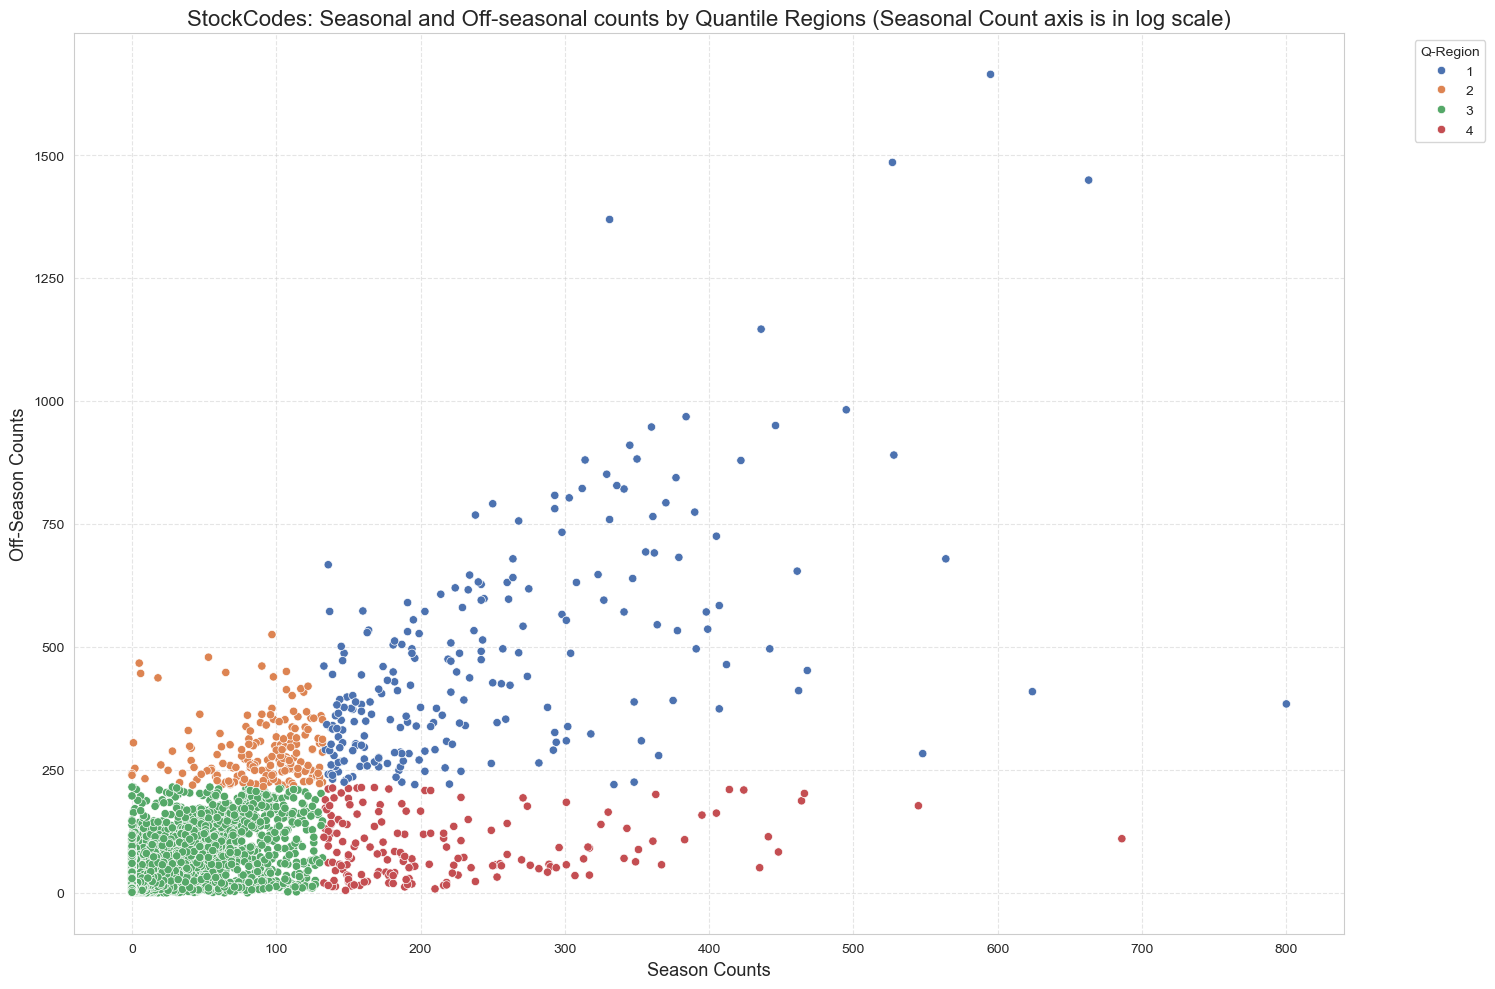

In [285]:
plt.figure(figsize=(15, 10))

g1 = sns.scatterplot(
    data=x,
    x='Season',
    y='Off-Season',
    hue='Q-Region',
    palette="deep"
)

# Uncomment if you want log scale
# g1.set_xscale("log")

plt.title('StockCodes: Seasonal and Off-seasonal counts by Quantile Regions (Seasonal Count axis is in log scale)', fontsize=16)
plt.xlabel('Season Counts', fontsize=13)
plt.ylabel('Off-Season Counts', fontsize=13)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Q-Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [287]:
x.head()
x.index.name
x.columns


Index(['StockCode', 'Season', 'Off-Season', 'cluster', 'Q-Region'], dtype='object')

In [289]:
# Step 1: Make StockCode a column
x_reset = x.reset_index()  # Now StockCode is a column again

# Step 2: Merge on 'StockCode'
df_merged = df.merge(
    x_reset,
    on='StockCode',  # now both sides have this column
    how='left'
)

# Step 3: Drop columns and rename
df_merged = df_merged.drop(['Season', 'Off-Season'], axis=1)
df_merged = df_merged.rename(columns={'cluster': 'ProductCluster'})


In [291]:
df = df_merged


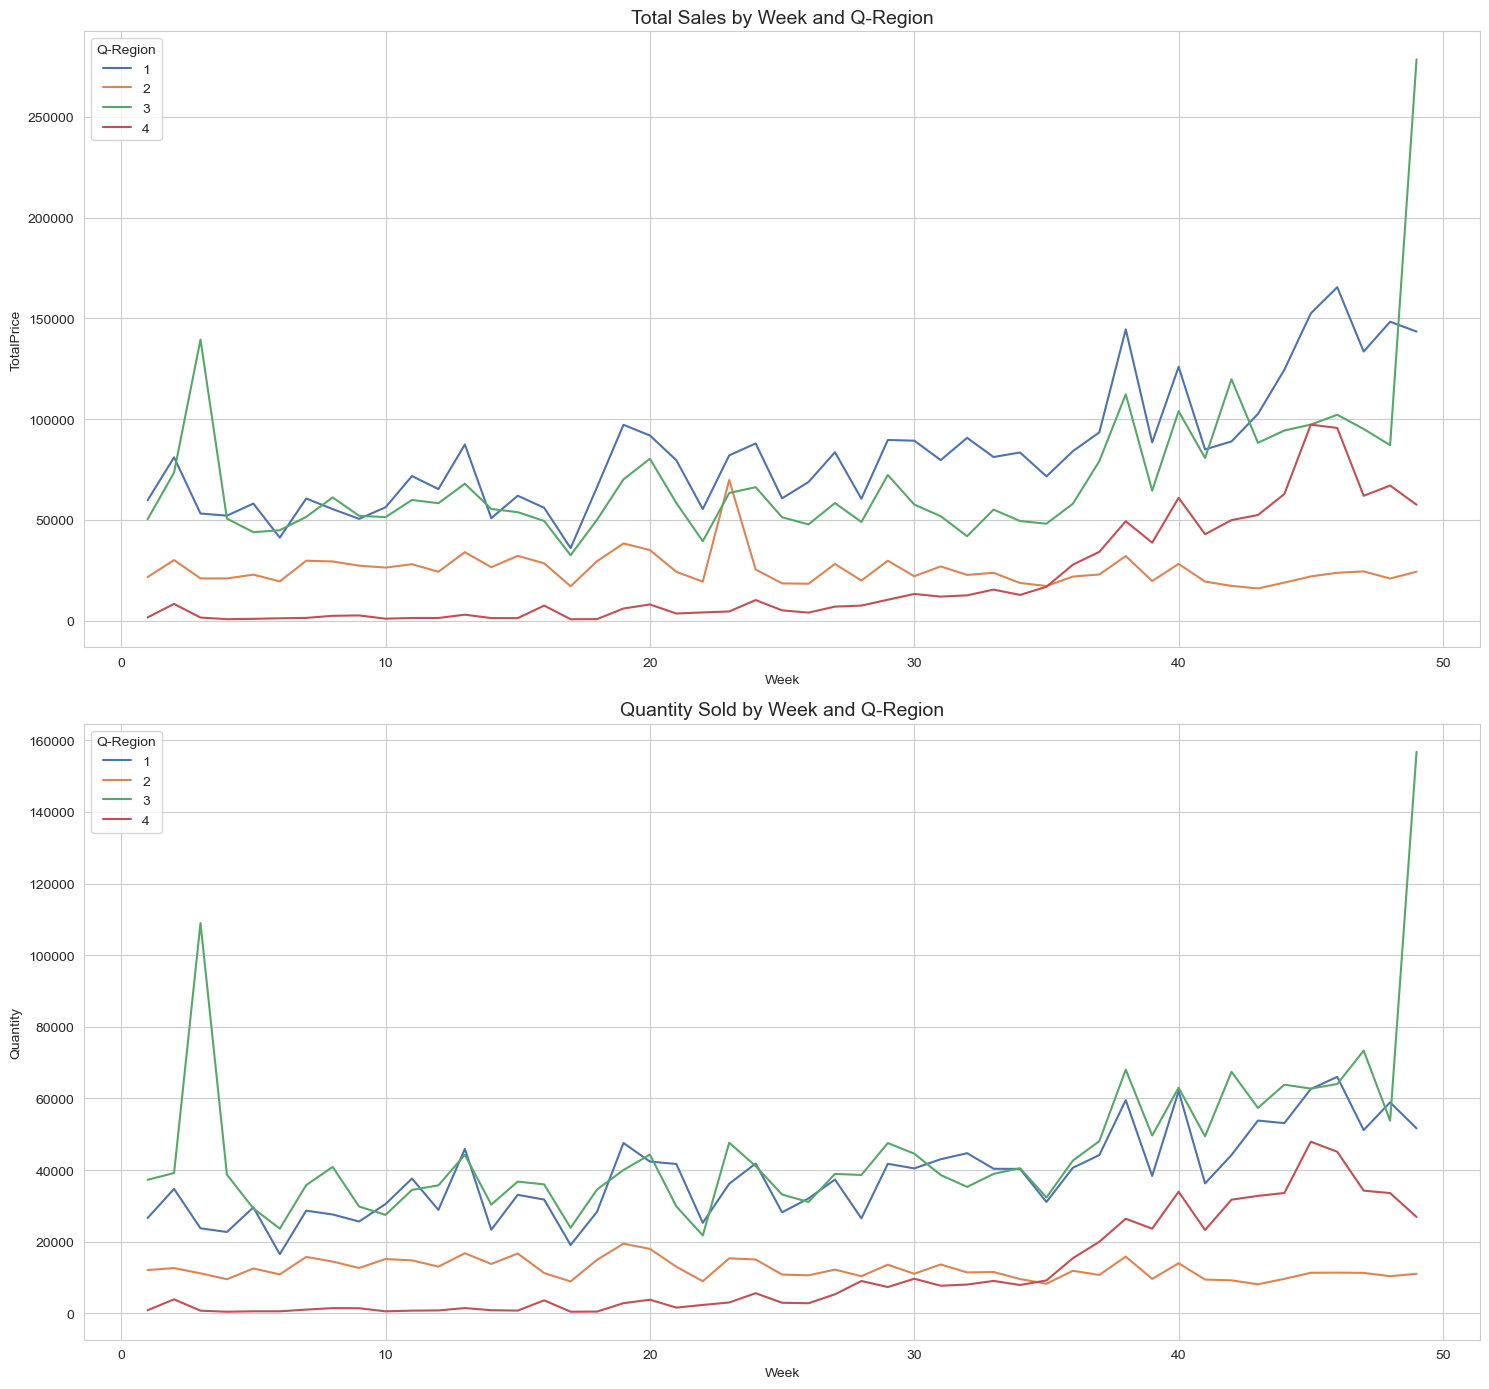

In [293]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 14))

# Filter data to valid quantities and year 2011
ddf = df[(df['Quantity'] > 0) & (df['InvoiceDate'].dt.year == 2011)]

# Group by week number and Q-Region
d = ddf.groupby([
    ddf['InvoiceDate'].dt.isocalendar().week,
    ddf['Q-Region']
]).agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'CustomerID': 'count'
}).reset_index().rename(columns={'week': 'Week'})

# Plot total price over time
sns.lineplot(data=d, x='Week', y='TotalPrice', hue='Q-Region', palette='deep', ax=ax[0])
ax[0].set_title('Total Sales by Week and Q-Region', fontsize=14)

# Plot quantity over time
sns.lineplot(data=d, x='Week', y='Quantity', hue='Q-Region', palette='deep', ax=ax[1])
ax[1].set_title('Quantity Sold by Week and Q-Region', fontsize=14)

plt.tight_layout()
plt.show()


In [295]:
Q1 = df[df['Q-Region']==1]
Q2 = df[df['Q-Region']==2]
Q3 = df[df['Q-Region']==3]
Q4 = df[df['Q-Region']==4]

In [297]:
Q1.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

UnitPrice  TotalPrice  Quantity
StockCode ProductName                                                        
DOT       DOTCOM POSTAGE                      206248.77   206248.77      1708
POST      POSTAGE                              34992.23    78101.88      6500
22423     REGENCY CAKESTAND 3 TIER             28065.76   174156.54     13809
47566     PARTY BUNTING                         9850.68    99445.23     18287
22720     SET OF 3 CAKE TINS PANTRY DESIGN      8120.53    38108.89      7433
85066     CREAM SWEETHEART MINI CHEST           7497.46    22594.20      1784
85123A    WHITE HANGING HEART T-LIGHT HOLDER    7024.49   104462.75     41389
22624     IVORY KITCHEN SCALES                  6727.86    16378.71      1910
22847     BREAD BIN DINER STYLE IVORY           6545.63    14389.34       896
23284     DOORMAT KEEP CALM AND COME IN         6424.24    38133.64      5485

In [299]:
Q2.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

UnitPrice  TotalPrice  Quantity
StockCode ProductName                                                      
22424     ENAMEL BREAD BIN CREAM              7216.03    12358.33       873
21843     RED RETROSPOT CAKE STAND            6820.69    21354.30      1949
22501     PICNIC BASKET WICKER LARGE          6408.71    19302.26      1565
22605     WOODEN CROQUET GARDEN SET           4867.47    11276.21       782
22502     PICNIC BASKET WICKER 60 PIECES      4800.89    51408.77      1945
22487     WHITE WOOD GARDEN PLANT LADDER      4663.66     7909.28       784
21621     VINTAGE UNION JACK BUNTING          4581.32    24525.83      2357
22844     VINTAGE CREAM DOG FOOD CONTAINER    4526.56     9661.32      1003
21524     DOORMAT SPOTTY HOME SWEET HOME      4427.39    13572.06      1752
21217     RED RETROSPOT ROUND CAKE TINS       4326.04    11522.44      1088

In [301]:
Q3.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

UnitPrice  TotalPrice  Quantity
StockCode ProductName                                                         
M         Manual                                74098.73    77750.27      6990
AMAZONFEE AMAZON FEE                            13761.09    13761.09         2
C2        CARRIAGE                               7033.00     7051.00       292
84078A    SET/4 WHITE RETRO STORAGE CUBES        7011.00    16363.30       415
22655     VINTAGE RED KITCHEN CABINET            5450.00     8125.00        49
22846     BREAD BIN DINER STYLE RED              4920.45    10676.62       665
22826     LOVE SEAT ANTIQUE WHITE METAL          4675.00     6210.00        58
22827     RUSTIC  SEVENTEEN DRAWER SIDEBOARD     4110.00     5415.00        31
21340     CLASSIC METAL BIRDCAGE PLANT HOLDER    3894.65    11300.02       975
22839     3 TIER CAKE TIN GREEN AND CREAM        3757.02     6981.67       445

In [303]:
Q4.groupby(['StockCode','ProductName'])[['UnitPrice','TotalPrice','Quantity']].sum().sort_values(by='UnitPrice',ascending=False).head(10)

UnitPrice  TotalPrice  Quantity
StockCode ProductName                                                         
23355     HOT WATER BOTTLE KEEP CALM             4196.16    28718.80      5816
22114     HOT WATER BOTTLE TEA AND SYMPATHY      3245.81    32973.44      5666
22941     CHRISTMAS LIGHTS 10 REINDEER           3098.46    13795.92      1670
23356     LOVE HOT WATER BOTTLE                  3015.93    13334.32      2359
23397     FOOT STOOL HOME SWEET HOME             2511.53     5097.65       480
85048     15CM CHRISTMAS GLASS BALL 20 LIGHTS    2447.73    10910.61      1359
23080     RED METAL BOX TOP SECRET               2437.55     9117.62      1074
23108     SET OF 10 LED DOLLY LIGHTS             2413.28    13290.52      2219
23313     VINTAGE CHRISTMAS BUNTING              2263.84    15798.66      2990
23328     SET 6 SCHOOL MILK BOTTLES IN CRATE     1981.88    13269.49      2841

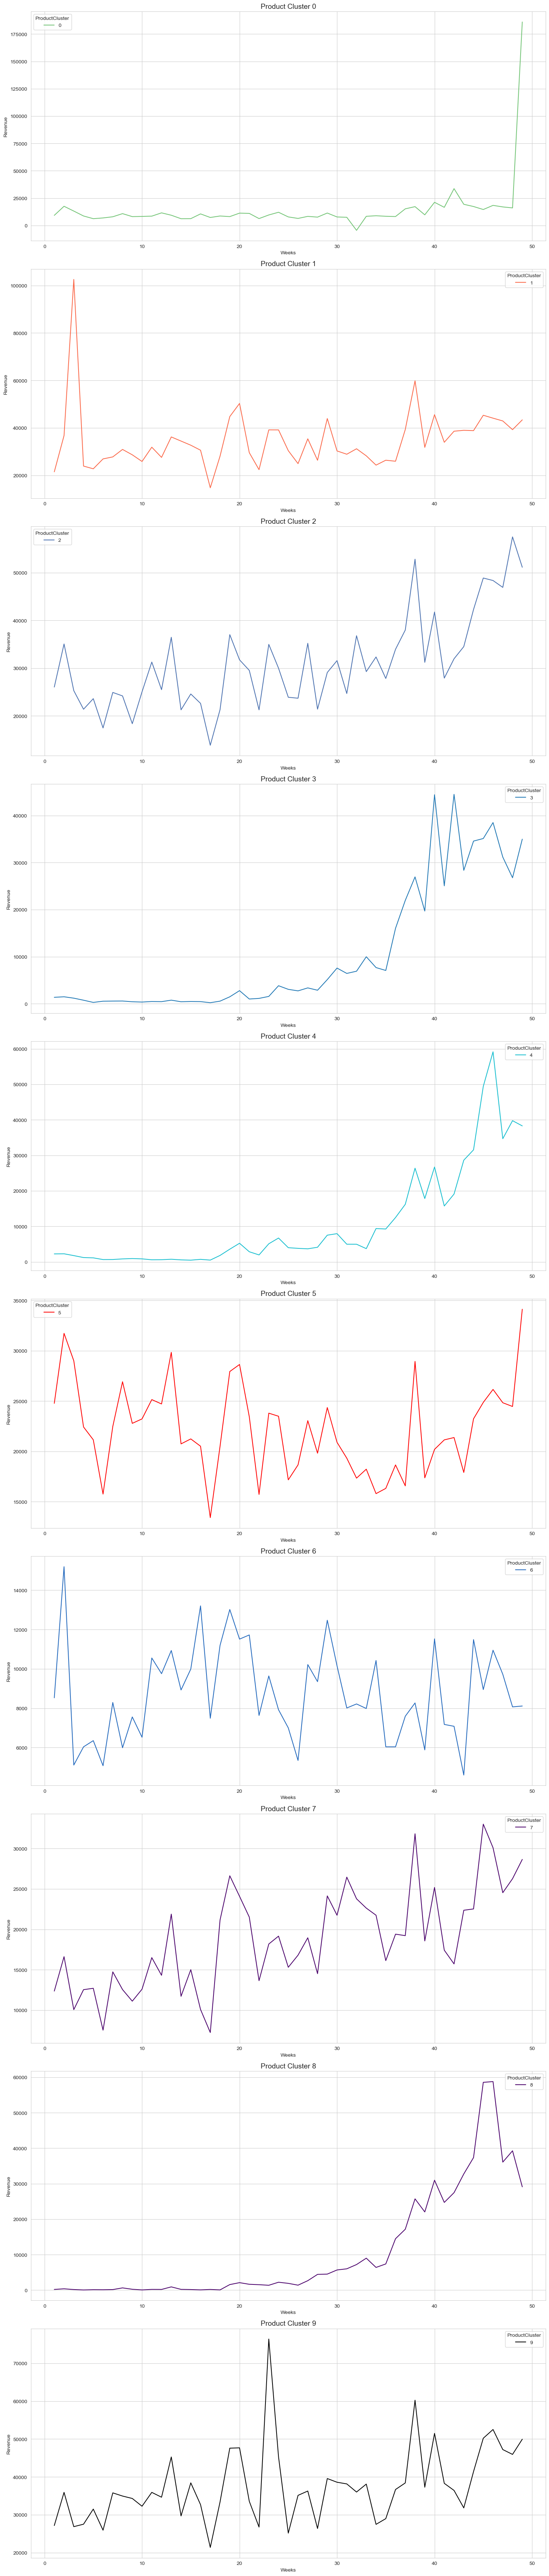

In [305]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure
fig, ax = plt.subplots(nrows=10, ncols=1, figsize=(15, 70))

# Filter for 2011 and positive quantities
ddf = df[(df['Quantity'] > 0) & (df["InvoiceDate"].dt.year == 2011)]

# Extract week numbers
ddf['Weeks'] = ddf['InvoiceDate'].dt.isocalendar().week

# Group by week and ProductCluster
d = ddf.groupby(['Weeks', 'ProductCluster']).agg({
    'TotalPrice': 'sum',
    'Quantity': 'sum',
    'CustomerID': 'count'
}).reset_index()

# Rename for clarity
d = d.rename(columns={'TotalPrice': 'Revenue'})

# Plot for each cluster
palettes = [
    "Greens", "Reds", "deep", "tab10", "tab10_r",
    "prism", "vlag", "RdPu_r", "RdPu_r", "CMRmap"
]

for i in range(10):
    sns.lineplot(
        data=d[d['ProductCluster'] == i],
        x='Weeks',
        y='Revenue',
        hue='ProductCluster',
        palette=palettes[i],
        ax=ax[i]
    )
    ax[i].set_title(f'Product Cluster {i}', fontsize=14)

plt.tight_layout()
plt.show()


In [306]:
basket_Germany = df[df['Country']=="Germany"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_EIRE = df[df['Country']=="EIRE"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_UK = df[df['Country']=="UK"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')
basket_France = df[df['Country']=="France"].groupby(['InvoiceNo', 'ProductName'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

In [307]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_Germany.drop('POSTAGE',axis=1,inplace=True)
basket_France.drop('POSTAGE',axis=1,inplace=True)

basket_Germany = basket_Germany.applymap(encode_units)
basket_EIRE = basket_EIRE.applymap(encode_units)
basket_UK = basket_UK.applymap(encode_units)
basket_France = basket_France.applymap(encode_units)

In [308]:
frequent_itemsets = apriori(basket_France, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

antecedents  \
0                         (ALARM CLOCK BAKELIKE RED )   
1                        (ALARM CLOCK BAKELIKE GREEN)   
2                         (ALARM CLOCK BAKELIKE PINK)   
3                         (ALARM CLOCK BAKELIKE RED )   
4                     (SET/6 RED SPOTTY PAPER PLATES)   
5   (SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...   
6                         (ALARM CLOCK BAKELIKE PINK)   
7                        (ALARM CLOCK BAKELIKE GREEN)   
8   (SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...   
9                       (SET/6 RED SPOTTY PAPER CUPS)   
10                    (SET/6 RED SPOTTY PAPER PLATES)   
11                      (SET/6 RED SPOTTY PAPER CUPS)   
12  (SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...   
13              (SET/20 RED RETROSPOT PAPER NAPKINS )   
14                    (SET/6 RED SPOTTY PAPER PLATES)   
15              (SET/20 RED RETROSPOT PAPER NAPKINS )   
16                              (SPACEBOY LUNCH BOX )   
17                             (DOLLY GIRL LUNCH BOX)   
18              (SET/20 RED RETROSPOT PAPER NAPKINS )   
19                      (SET/6 RED SPOTTY PAPER CUPS)   
20                 (PLASTERS IN TIN WOODLAND ANIMALS)   
21                         (PLASTERS IN TIN SPACEBOY)   
22                         (PLASTERS IN TIN SPACEBOY)   
23                   (PLASTERS IN TIN CIRCUS PARADE )   
24                 (PLASTERS IN TIN WOODLAND ANIMALS)   
25                   (PLASTERS IN TIN CIRCUS PARADE )   

                                          consequents  antecedent support  \
0                        (ALARM CLOCK BAKELIKE GREEN)            0.094388   
1                         (ALARM CLOCK BAKELIKE RED )            0.096939   
2                         (ALARM CLOCK BAKELIKE RED )            0.102041   
3                         (ALARM CLOCK BAKELIKE PINK)            0.094388   
4   (SET/20 RED RETROSPOT PAPER NAPKINS , SET/6 RE...            0.127551   
5                     (SET/6 RED SPOTTY PAPER PLATES)            0.102041   
6                        (ALARM CLOCK BAKELIKE GREEN)            0.102041   
7                         (ALARM CLOCK BAKELIKE PINK)            0.096939   
8                       (SET/6 RED SPOTTY PAPER CUPS)            0.102041   
9   (SET/6 RED SPOTTY PAPER PLATES, SET/20 RED RET...            0.137755   
10                      (SET/6 RED SPOTTY PAPER CUPS)            0.127551   
11                    (SET/6 RED SPOTTY PAPER PLATES)            0.137755   
12              (SET/20 RED RETROSPOT PAPER NAPKINS )            0.122449   
13  (SET/6 RED SPOTTY PAPER PLATES, SET/6 RED SPOT...            0.132653   
14              (SET/20 RED RETROSPOT PAPER NAPKINS )            0.127551   
15                    (SET/6 RED SPOTTY PAPER PLATES)            0.132653   
16                             (DOLLY GIRL LUNCH BOX)            0.125000   
17                              (SPACEBOY LUNCH BOX )            0.099490   
18                      (SET/6 RED SPOTTY PAPER CUPS)            0.132653   
19              (SET/20 RED RETROSPOT PAPER NAPKINS )            0.137755   
20                         (PLASTERS IN TIN SPACEBOY)            0.170918   
21                 (PLASTERS IN TIN WOODLAND ANIMALS)            0.137755   
22                   (PLASTERS IN TIN CIRCUS PARADE )            0.137755   
23                         (PLASTERS IN TIN SPACEBOY)            0.168367   
24                   (PLASTERS IN TIN CIRCUS PARADE )            0.170918   
25                 (PLASTERS IN TIN WOODLAND ANIMALS)            0.168367   

    consequent support   support  confidence      lift  representativity  \
0             0.096939  0.079082    0.837838  8.642959               1.0   
1             0.094388  0.079082    0.815789  8.642959               1.0   
2             0.094388  0.073980    0.725000  7.681081               1.0   
3             0.102041  0.073980    0.783784  7.681081               1.0   
4             0.102041  0.099490    0.7800

In [309]:
frequent_itemsets = apriori(basket_Germany, min_support=0.07, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.sort_values(['lift','support'],ascending=False).reset_index(drop=True)

antecedents  \
0   (ROUND SNACK BOXES SET OF 4 FRUITS )   
1  (ROUND SNACK BOXES SET OF4 WOODLAND )   
2                  (SPACEBOY LUNCH BOX )   
3  (ROUND SNACK BOXES SET OF4 WOODLAND )   
4  (ROUND SNACK BOXES SET OF4 WOODLAND )   
5     (PLASTERS IN TIN WOODLAND ANIMALS)   

                             consequents  antecedent support  \
0  (ROUND SNACK BOXES SET OF4 WOODLAND )            0.157549   
1   (ROUND SNACK BOXES SET OF 4 FRUITS )            0.245077   
2  (ROUND SNACK BOXES SET OF4 WOODLAND )            0.102845   
3                  (SPACEBOY LUNCH BOX )            0.245077   
4     (PLASTERS IN TIN WOODLAND ANIMALS)            0.245077   
5  (ROUND SNACK BOXES SET OF4 WOODLAND )            0.137856   

   consequent support   support  confidence      lift  representativity  \
0            0.245077  0.131291    0.833333  3.400298               1.0   
1            0.157549  0.131291    0.535714  3.400298               1.0   
2            0.245077  0.070022    0.680851  2.778116               1.0   
3            0.102845  0.070022    0.285714  2.778116               1.0   
4            0.137856  0.074398    0.303571  2.202098               1.0   
5            0.245077  0.074398    0.539683  2.202098               1.0   

   leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
0  0.092679    4.529540       0.837922  0.483871   0.779227    0.684524  
1  0.092679    1.814509       0.935072  0.483871   0.448887    0.684524  
2  0.044817    2.365427       0.713415  0.251969   0.577243    0.483283  
3  0.044817    1.256018       0.847826  0.251969   0.203833    0.483283  
4  0.040613    1.237951       0.723103  0.241135   0.192214    0.421627  
5  0.040613    1.640006       0.633174  0.241135   0.390246    0.421627